# Preliminaries

In [1]:
#import libraries
import pandas as pd
print('pandas: %s' % pd.__version__)

pd.options.display.max_columns = None
pd.set_option('display.max_rows', 150)

import numpy as np
print('geopandas: %s' % np.__version__)

# Tensorflow / Keras
import tensorflow as tf # used to access argmax function
from tensorflow import keras # for building Neural Networks
print('Tensorflow/Keras: %s' % keras.__version__) # print version
from keras import Sequential # for creating a linear stack of layers for our Neural Network
from keras import Input # for instantiating a keras tensor
from keras.layers import Dense # for creating regular densely-connected NN layer.
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout # for adding Concolutional and densely-connected NN layers.
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Input, Flatten,\
                                    Reshape, LeakyReLU as LR,\
                                    Activation, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

# Data manipulation
import pandas as pd # for data manipulation
print('pandas: %s' % pd.__version__) # print version
import numpy as np # for data manipulation
print('numpy: %s' % np.__version__) # print version

import decimal
from decimal import Decimal

import keras 
import tensorflow as tf
from tensorflow.keras.layers import Dropout,BatchNormalization,Conv2D,MaxPooling2D,Dense,Flatten
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import regularizers
from keras import callbacks
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.layers import Dense # for creating regular densely-connected NN layer.
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout,MaxPooling2D # for adding Concolutional and densely-connected NN layers.
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential

from pathlib import Path  

from sklearn.model_selection import train_test_split # for splitting the data into train and test samples
from sklearn.metrics import classification_report # for model evaluation metrics
from sklearn.preprocessing import OrdinalEncoder # for encoding labels
from keras.models import load_model
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

from tensorflow.keras.utils import plot_model

from sklearn.utils.class_weight import compute_sample_weight

import pickle

pandas: 1.5.0
geopandas: 1.23.2
Tensorflow/Keras: 2.10.0
pandas: 1.5.0
numpy: 1.23.2


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import brier_score_loss

def plot_roc(pred,y):
    fpr, tpr, _ = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

In [3]:
# slow
def extract_images(df, variables, verbose=False):
    number_of_img, rows, cols = len(df.time.unique()), len(df.latitude.unique()), len(df.longitude.unique())
    images = np.zeros( (number_of_img, rows, cols, len(variables)) )
    
    df = df.sort_values(by=['time','latitude','longitude'])
    k=0
    
    for day in range(0,number_of_img):
        
        a=df.iloc[377*day:377*(day+1)]
        i=0
        for var in variables:
            images[day,:,:,i] = a.pivot(index='latitude', columns='longitude').sort_index(ascending=False)[var]
            i+=1
        k+=1
        if (k%100==0) & (verbose==True): print(k)
    return images

In [4]:
# faster
def extract_images_new(df, n_filters, verbose=False):
    times = df.time.unique()
    number_of_img, rows, cols = len(times), len(df.latitude.unique()), len(df.longitude.unique())
    images = np.zeros( (number_of_img, rows, cols, n_filters) )
    
    df = df.set_index(['time','latitude','longitude'], drop=True)
    df.sort_index(level=['time','latitude', 'longitude'], ascending=[1,0,1], inplace=True)
    k=0
    
    for day in range(0,number_of_img):
        
        images[k,:,:,:] = df.loc(axis=0)[times[day]].values.reshape(rows,cols,n_filters)
        if (k%100==0) & (verbose==True): print(k)
        k += 1
    return images


In [5]:
train = pd.read_csv('/Users/paolo/Documents/TC_old/data/NewData_csv/training_sets_withrealtom.csv')
val = pd.read_csv('/Users/paolo/Documents/TC_old/data/NewData_csv/validation_sets_withrealtom.csv')
test = pd.read_csv('/Users/paolo/Documents/TC_old/data/NewData_csv/test_sets_withrealtom.csv')
test = test.loc[test.time>='2016-04-01']

#train['shear'] = train.apply(lambda x: np.sqrt((x.u_200-x.u_850)**2 + (x.v_200-x.v_850)**2),axis=1)
#val['shear'] = val.apply(lambda x: np.sqrt((x.u_200-x.u_850)**2 + (x.v_200-x.v_850)**2),axis=1)
#test['shear'] = test.apply(lambda x: np.sqrt((x.u_200-x.u_850)**2 + (x.v_200-x.v_850)**2),axis=1)


In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

cols_to_std = [ 'vo', 'r', 'u_200', 'u_850', 'v_200','v_850', 'ttr','sst','shear']
train_std,val_std,test_std = train,val,test

# apply standardization on numerical features
train_std[cols_to_std] = scaler.fit_transform(train[[ 'vo', 'r', 'u_200', 'u_850', 'v_200','v_850', 'ttr','sst','shear']])
val_std[cols_to_std] = scaler.transform(val[[ 'vo', 'r', 'u_200', 'u_850', 'v_200','v_850', 'ttr','sst','shear']])
test_std[cols_to_std] = scaler.transform(test[[ 'vo', 'r', 'u_200', 'u_850', 'v_200','v_850', 'ttr','sst','shear']])


In [24]:
%%time
#training set has 11323 days
variables = [ 'vo', 'r', 'u_200', 'u_850', 'v_200','v_850', 'ttr','sst','shear']
train_img_std = extract_images(train_std, variables, verbose=True)
print(train_img_std.shape)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
(11323, 13, 29, 9)
CPU times: user 2min 11s, sys: 676 ms, total: 2min 12s
Wall time: 2min 12s


In [30]:
%%time
#training set has 11323 days
train_std_red = train_std.loc[:,['time','latitude','longitude','vo', 'r', 'u_200', 'u_850', 'v_200','v_850', 'ttr','sst','shear']]
train_img_std_new = extract_images_new(train_std_red, 9, verbose=True)
print(train_img_std.shape)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
(11323, 13, 29, 9)
CPU times: user 1.7 s, sys: 843 ms, total: 2.54 s
Wall time: 3.02 s


In [33]:
train_img_std_new[(train_img_std_new-train_img_std)>0]

array([], dtype=float64)

# World test

In [11]:
%%time
new_test = pd.read_csv('/Users/paolo/Desktop/TC_world/test_world.csv')
new_test['shear'] = np.sqrt((new_test['u_200']-new_test['u_850'])**2 + (new_test['v_200']-new_test['v_850'])**2)


CPU times: user 6.99 s, sys: 1.95 s, total: 8.95 s
Wall time: 15.9 s


In [12]:
new_test

Unnamed: 0        time  latitude  longitude        vo          r  \
0                  0  2016-01-01      90.0        0.0  0.000043  81.503310   
1                  1  2016-01-01      90.0        2.5  0.000045  81.257750   
2                  2  2016-01-01      90.0        5.0  0.000047  81.058260   
3                  3  2016-01-01      90.0        7.5  0.000049  80.905945   
4                  4  2016-01-01      90.0       10.0  0.000051  80.799100   
...              ...         ...       ...        ...       ...        ...   
13439587     1918435  2022-12-31     -90.0      167.5  0.000016  97.887580   
13439588     1918436  2022-12-31     -90.0      170.0  0.000016  97.870000   
13439589     1918437  2022-12-31     -90.0      172.5  0.000017  97.856330   
13439590     1918438  2022-12-31     -90.0      175.0  0.000017  97.844610   
13439591     1918439  2022-12-31     -90.0      177.5  0.000017  97.828990   

              u_200     u_850      v_200     v_850        ttr        sst  \
0         12.107742 -5.164993  17.249031 -4.722889 -170.39037  271.45947   
1         12.948624 -5.211590  16.924652 -4.370609 -170.39037  271.45947   
2         13.782364 -5.238873  16.558777 -4.030861 -170.94148  271.45947   
3         14.606613 -5.250248  16.149963 -3.704582 -171.19629  271.45947   
4         15.419373 -5.248001  15.697968 -3.391552 -171.17259  271.45947   
...             ...       ...        ...       ...        ...        ...   
13439587  -1.422317  2.364288  -3.507492  0.720871 -182.42667    0.00000   
13439588  -1.215286  2.370148  -3.650070  0.809738 -182.44444    0.00000   
13439589  -1.002396  2.372101  -3.778976  0.898605 -182.46222    0.00000   
13439590  -0.783646  2.370148  -3.892258  0.987473 -182.58667    0.00000   
13439591  -0.555130  2.364288  -3.987961  1.074387 -182.76445    0.00000   

          new_target  Real_tom_target      shear  
0                0.0              0.0  27.948393  
1                0.0              0.0  27.987167  
2                0.0              0.0  28.031065  
3                0.0              0.0  28.080205  
4                0.0              0.0  28.134501  
...              ...              ...        ...  
13439587         0.0              0.0   5.676041  
13439588         0.0              0.0   5.722345  
13439589         0.0              0.0   5.767755  
13439590         0.0              0.0   5.810179  
13439591         0.0              0.0   5.843831  

[13439592 rows x 15 columns]

In [45]:
%%time
variables = ['time','latitude','longitude', 'vo', 'r', 'u_200', 'u_850', 'v_200','v_850', 'ttr','sst']
new_test_img =  extract_images_new(new_test.loc[:,variables], 8, verbose=True)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
CPU times: user 3.16 s, sys: 3.78 s, total: 6.94 s
Wall time: 24.9 s


# Read world images

In [79]:
def evaluate_perf(model, test_inputs,test_outputs,day=0):
    t = model.predict(test_inputs)
    one_day_t = t
    one_day_y = test_outputs
    
    ranges = [0.025,0.05,0.075,0.1]
    
    for j in ranges:
        classes = []
        for i in one_day_t.reshape(-1,1):
            if i<=j: classes.append(0)
            else: classes.append(1)
    
    # confusion matrix with threshold on 0.1, otherwise always 0 
        ConfusionMatrixDisplay(confusion_matrix(one_day_y.reshape(-1,1), classes)).plot(colorbar=False,cmap=plt.cm.Blues, values_format='d')
        ConfusionMatrixDisplay(confusion_matrix(one_day_y.reshape(-1,1), classes, normalize='true')).plot(colorbar=False,cmap=plt.cm.Blues)
    
    plot_roc(one_day_t.reshape(-1,1),one_day_y.reshape(-1,1))
    
    display = CalibrationDisplay.from_predictions(one_day_y.reshape(-1,1), one_day_t.reshape(-1,1), n_bins=10)

    print(f'All zeros Brier score: {brier_score_loss(one_day_y.reshape(-1,1), np.zeros(len(one_day_y.reshape(-1,1))))}')
    print(f'Model Brier score: {brier_score_loss(one_day_y.reshape(-1,1), one_day_t.reshape(-1,1))}')
    

In [8]:
### features
#train = pd.read_pickle('/Users/paolo/Desktop/TC_world/train_world_img.pkl')
val = pd.read_pickle('/Users/paolo/Desktop/TC_world/val_world_img.pkl')
test = pd.read_pickle('/Users/paolo/Desktop/TC_world/test_world_img.pkl')
test.shape

(2557, 73, 72, 9)

In [14]:
minitrain = train[0:64,:,:,:]
minival = val[0:64,:,:,:]

In [4]:
### target

train_target = pd.read_pickle('/Users/paolo/Desktop/TC_world/train_target_img.pkl')
val_target = pd.read_pickle('/Users/paolo/Desktop/TC_world/val_target_img.pkl')
test_target = pd.read_pickle('/Users/paolo/Desktop/TC_world/test_target_img.pkl')

In [5]:
val_target = pd.read_pickle('/Users/paolo/Desktop/TC_world/val_target_img.pkl')
val_target.shape

(1826, 13, 29, 1)

In [16]:
minitrain_target = train_target[0:64,:,:,:]
minival_target = val_target[0:64,:,:,:]

In [45]:
def Generator(File_address, target_address , Batch_Size):
    #while True:
    pickle_data = pd.read_pickle(File_address)
    pickle_target = pd.read_pickle(target_address)
        #with (open(File_address, "rb")) as openfile: 
        #    while True:
        #        pickle_data.append(pickle.load(openfile))
        #with (open(target_address, "rb")) as openfile: 
        #        pickle_target.append(pickle.load(openfile))
    while True:
        for B in range(0, len(pickle_data), Batch_Size):
            X = pickle_data[B:B+Batch_Size]
            Y = pickle_target[B:B+Batch_Size] 
            yield X, Y


In [31]:
train_path = '/Users/paolo/Desktop/TC_world/val_world_img.pkl'
train_target_path = '/Users/paolo/Desktop/TC_world/val_target_img.pkl'
#x1,y1 = Generator(train_path, train_target_path, 32)
#print(x1)
#print(y1)
x = Generator(train_path, train_target_path, 32)

In [32]:
for i,j in x:
    print(i,j)

[[[[ 4.32046121e-01  1.10626916e+00 -3.91840987e-02 ...  1.35543217e+00
     7.21149932e-01 -1.97251871e-01]
   [ 4.54648028e-01  1.09339941e+00 -6.18523688e-02 ...  1.35543217e+00
     7.21149932e-01 -1.99024882e-01]
   [ 4.77958864e-01  1.08008746e+00 -8.53457871e-02 ...  1.35506447e+00
     7.21149932e-01 -2.00725360e-01]
   ...
   [-1.14492789e-01  1.55189199e+00 -1.44512711e+00 ...  1.34758906e+00
     7.21149932e-01 -3.49193553e-01]
   [-1.26067927e-01  1.55523588e+00 -1.43282469e+00 ...  1.34709895e+00
     7.21149932e-01 -3.50695487e-01]
   [-1.40394824e-01  1.55698993e+00 -1.41900119e+00 ...  1.34642498e+00
     7.21149932e-01 -3.52102154e-01]]

  [[ 1.00725360e+00  4.83291335e-01 -2.78963075e-02 ...  1.31168235e+00
     7.21149932e-01 -1.52502826e-01]
   [ 1.02556611e+00  5.01399495e-01 -6.04584607e-02 ...  1.29029776e+00
     7.21149932e-01 -1.65820773e-01]
   [ 1.03302101e+00  5.21886451e-01 -9.33458917e-02 ...  1.26854549e+00
     7.21149932e-01 -1.79403128e-01]
   ...
   

    -1.20212225e+00 -2.31305434e-01]]]] [[[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]

# basic CNN

In [36]:
model = Sequential()
model.add(layers.Input(shape=(73,72, 9)))

model.add(layers.Conv2D(8, (5,5), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((3,3), padding='same'))

#model.add(layers.Flatten())

#model.add(layers.Reshape((2,4,16)))

model.add(layers.Conv2D(8, (5,5), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((3,3), padding='same'))

model.add(layers.Conv2D(8, (5,5), activation='relu', padding='same'))
model.add(layers.UpSampling2D((2,4)))

model.add(layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')) # sigmoidal activation to have probabilities

model.add(layers.Cropping2D(cropping=((2,3),(1,2))))

model.summary()


model.compile(loss='binary_crossentropy', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=20, 
        verbose=1, mode='auto', restore_best_weights=True)


Metal device set to: Apple M1


2023-04-13 07:39:35.253742: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-13 07:39:35.256406: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 73, 72, 8)         1808      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 24, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 24, 8)         1608      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 8, 8)          0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 8, 8)           1608      
                                                                 
 up_sampling2d (UpSampling2D  (None, 18, 32, 8)        0

In [48]:
train_path = '/Users/paolo/Desktop/TC_world/train_world_img.pkl'
train_target_path = '/Users/paolo/Desktop/TC_world/train_target_img.pkl'
val_path = '/Users/paolo/Desktop/TC_world/val_world_img.pkl'
val_target_path = '/Users/paolo/Desktop/TC_world/val_target_img.pkl'

train_gen = Generator(train_path, train_target_path, 32)
val_gen = Generator(val_path, val_target_path, 32)

#Model.fit(train_gen, epochs=100, steps_per_epoch=Number_of_sampels//32)
model.fit(train_gen, validation_data=val_gen,
        callbacks=[monitor],epochs=100, steps_per_epoch=11323//32, validation_steps=1826//32)

Epoch 1/100
353/353 [==============================] - 23s 64ms/step - loss: 0.0235 - val_loss: 0.0205
Epoch 2/100
353/353 [==============================] - 27s 74ms/step - loss: 0.0232 - val_loss: 0.0203
Epoch 3/100
353/353 [==============================] - 19s 54ms/step - loss: 0.0229 - val_loss: 0.0200
Epoch 4/100
353/353 [==============================] - 25s 70ms/step - loss: 0.0227 - val_loss: 0.0197
Epoch 5/100
353/353 [==============================] - 26s 73ms/step - loss: 0.0224 - val_loss: 0.0192
Epoch 6/100
353/353 [==============================] - 16s 47ms/step - loss: 0.0220 - val_loss: 0.0187
Epoch 7/100
353/353 [==============================] - 19s 53ms/step - loss: 0.0213 - val_loss: 0.0174
Epoch 8/100
353/353 [==============================] - 15s 41ms/step - loss: 0.0199 - val_loss: 0.0156
Epoch 9/100
353/353 [==============================] - 14s 40ms/step - loss: 0.0183 - val_loss: 0.0140
Epoch 10/100
353/353 [==============================] - 15s 44ms/step - l

78/78 [==============================] - 1s 9ms/step


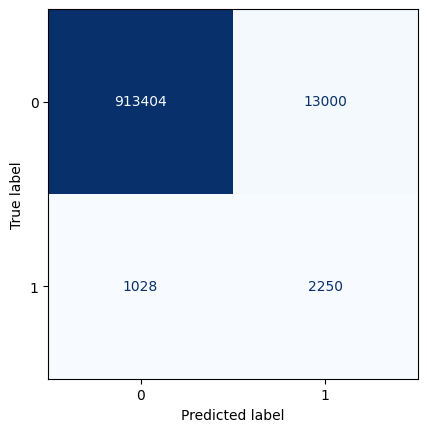

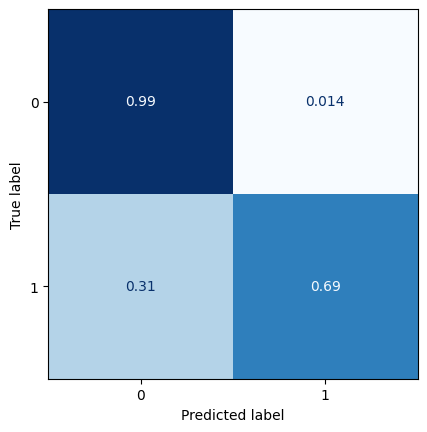

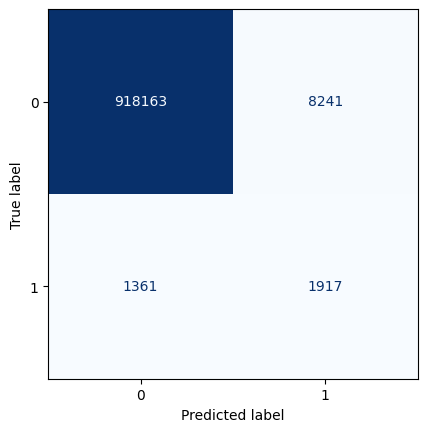

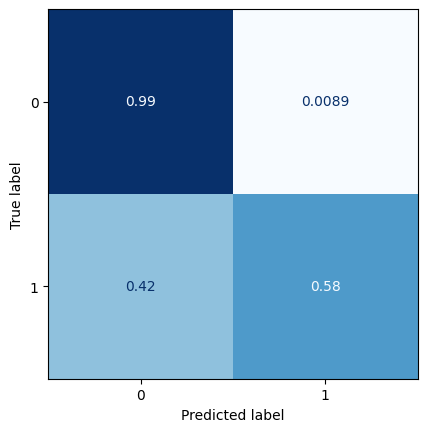

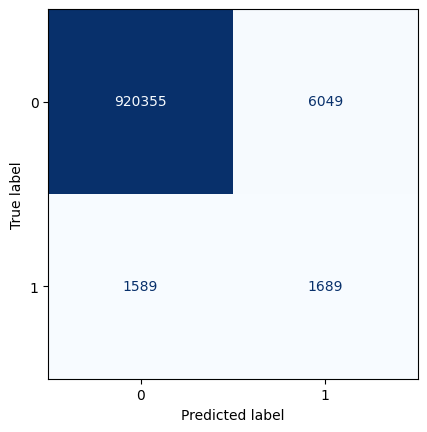

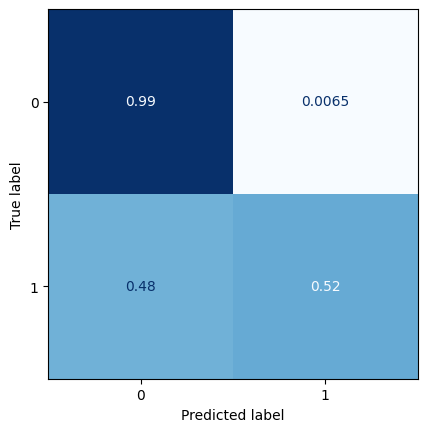

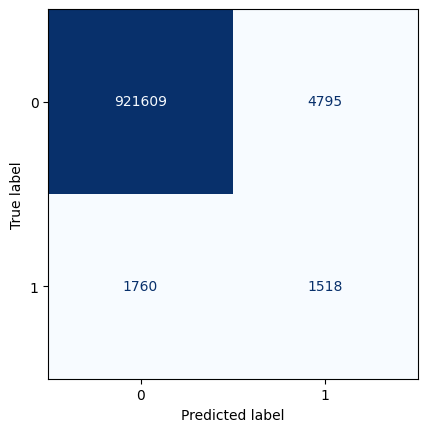

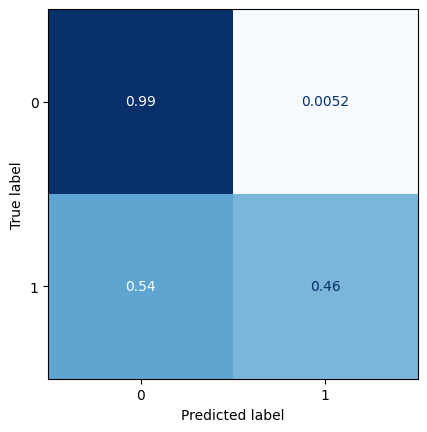

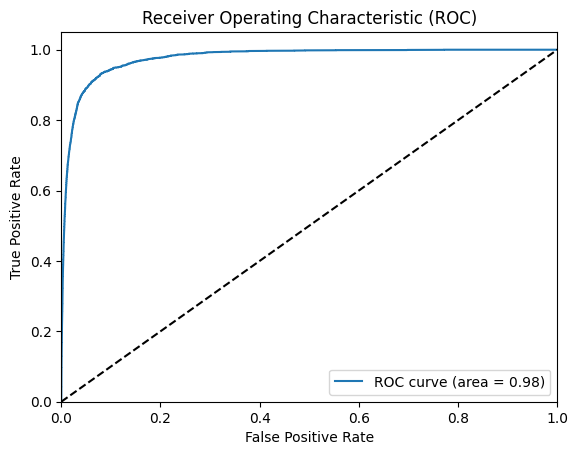

All zeros Brier score: 0.0035259368257102965
Model Brier score: 0.003016965153756049


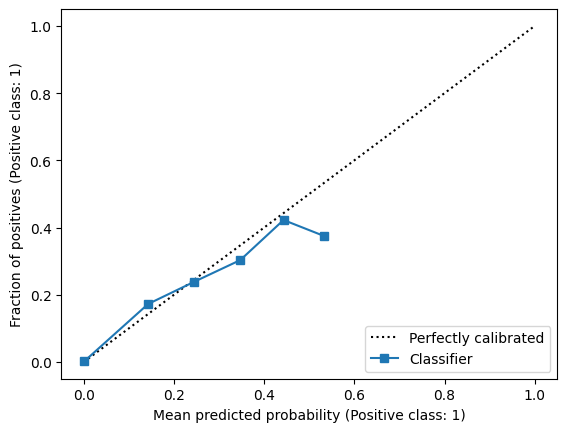

In [59]:
test = pd.read_pickle('/Users/paolo/Desktop/TC_world/test_world_img.pkl')
test_target = pd.read_pickle('/Users/paolo/Desktop/TC_world/test_target_img.pkl')
evaluate_perf(test[91:],test_target,day=0)


### generator

In [9]:
from keras.preprocessing.image import ImageDataGenerator
train_dir = '/Users/paolo/Desktop/TC_world/train_world_img.pkl'
val_dir = '/Users/paolo/Desktop/TC_world/val_world_img.pkl'
train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

In [10]:
train_generator = train_datagen.flow_from_directory(train_dir,batch_size=20)
val_generator = val_datagen.flow_from_directory(val_dir,batch_size=20)

NotADirectoryError: [Errno 20] Not a directory: '/Users/paolo/Desktop/TC_world/train_world_img.pkl'

In [ ]:
train_generator = train_datagen.flow_from_directory(
 # This is the target directory
 train_dir,
 # All images will be resized to 150x150
 target_size=(150, 150),
 batch_size=20,
 # Since we use binary_crossentropy loss, we need binary labels
 class_mode='binary')

In [9]:
model.fit(minitrain, minitrain_target, validation_data=(minival,minival_target),
        callbacks=[monitor],epochs=100, batch_size=32)

Epoch 1/100


2023-04-05 17:44:37.440524: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-05 17:44:37.818343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 0.2977 - val_loss: 0.1988
Epoch 2/100
1/1 [==============================] - 0s 59ms/step - loss: 0.2202 - val_loss: 0.1306
Epoch 3/100
1/1 [==============================] - 0s 43ms/step - loss: 0.1581 - val_loss: 0.0792
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.1135

2023-04-05 17:44:38.723669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 48ms/step - loss: 0.1135 - val_loss: 0.0451
Epoch 5/100
1/1 [==============================] - 0s 49ms/step - loss: 0.0873 - val_loss: 0.0250
Epoch 6/100
1/1 [==============================] - 0s 47ms/step - loss: 0.0766 - val_loss: 0.0144
Epoch 7/100
1/1 [==============================] - 0s 50ms/step - loss: 0.0753 - val_loss: 0.0088
Epoch 8/100
1/1 [==============================] - 0s 46ms/step - loss: 0.0776 - val_loss: 0.0059
Epoch 9/100
1/1 [==============================] - 0s 47ms/step - loss: 0.0803 - val_loss: 0.0043
Epoch 10/100
1/1 [==============================] - 0s 45ms/step - loss: 0.0821 - val_loss: 0.0034
Epoch 11/100
1/1 [==============================] - 0s 42ms/step - loss: 0.0827 - val_loss: 0.0029
Epoch 12/100
1/1 [==============================] - 0s 41ms/step - loss: 0.0823 - val_loss: 0.0026
Epoch 13/100
1/1 [==============================] - 0s 44ms/step - loss: 0.0810 - val_loss: 0.0026
Epoch 14/100
1/1 [==========

# Full Earth

## usual CNN

In [6]:
def Generator(File_address, target_address, year_start, year_end):
    #while True:
    pickle_target = pd.read_pickle(target_address)
    
        #with (open(File_address, "rb")) as openfile: 
        #    while True:
        #        pickle_data.append(pickle.load(openfile))
        #with (open(target_address, "rb")) as openfile: 
        #        pickle_target.append(pickle.load(openfile))
    while True:
        i=0
        for year in range(year_start,year_end+1):
            X = np.load(File_address+'img_'+str(year)+'.npy')
            X = X[:,:,:,:-1]
            Y = pickle_target[i:i+X.shape[0]] 
            i += X.shape[0]
            yield X, Y

In [7]:
File_address='/Users/paolo/Documents/TC_old/data/earth_features/train_imgs/'
target_address = '/Users/paolo/Desktop/TC_world/train_target_img.pkl'


In [63]:
model = Sequential()
model.add(layers.Input(shape=(73,144, 9)))

model.add(layers.Conv2D(8, (5,5), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((3,3), padding='same'))

#model.add(layers.Flatten())

#model.add(layers.Reshape((2,4,16)))

model.add(layers.Conv2D(8, (5,5), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((3,3), padding='same'))

model.add(layers.Conv2D(8, (5,5), activation='relu', padding='same'))
model.add(layers.UpSampling2D((2,2)))

model.add(layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')) # sigmoidal activation to have probabilities

model.add(layers.Cropping2D(cropping=((2,3),(1,2))))

model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=10, 
        verbose=1, mode='auto', restore_best_weights=True)


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_54 (Conv2D)          (None, 73, 144, 8)        1808      
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 25, 48, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_55 (Conv2D)          (None, 25, 48, 8)         1608      
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 9, 16, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_56 (Conv2D)          (None, 9, 16, 8)          1608      
                                                                 
 up_sampling2d_16 (UpSamplin  (None, 18, 32, 8)      

In [64]:
train_path = '/Users/paolo/Documents/TC_old/data/earth_features/train_imgs/'
train_target_path = '/Users/paolo/Desktop/TC_world/train_target_img.pkl'
val_path = '/Users/paolo/Documents/TC_old/data/earth_features/val_imgs/'
val_target_path = '/Users/paolo/Desktop/TC_world/val_target_img.pkl'

train_gen = Generator(train_path, train_target_path, 1980, 2010)
val_gen = Generator(val_path, val_target_path, 2011, 2015)

#Model.fit(train_gen, epochs=100, steps_per_epoch=Number_of_sampels//32)
model.fit(train_gen, validation_data=val_gen,
        callbacks=[monitor],epochs=100, steps_per_epoch=31, validation_steps=5)

Epoch 1/100


2023-06-17 01:10:54.571666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - ETA: 0s - loss: 0.0873

2023-06-17 01:11:58.792101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 73s 2s/step - loss: 0.0873 - val_loss: 0.0344
Epoch 2/100
31/31 [==============================] - 67s 2s/step - loss: 0.0323 - val_loss: 0.0270
Epoch 3/100
31/31 [==============================] - 43s 1s/step - loss: 0.0287 - val_loss: 0.0250
Epoch 4/100
31/31 [==============================] - 39s 1s/step - loss: 0.0272 - val_loss: 0.0240
Epoch 5/100
31/31 [==============================] - 42s 1s/step - loss: 0.0261 - val_loss: 0.0231
Epoch 6/100
31/31 [==============================] - 42s 1s/step - loss: 0.0251 - val_loss: 0.0223
Epoch 7/100
31/31 [==============================] - 44s 1s/step - loss: 0.0243 - val_loss: 0.0216
Epoch 8/100
31/31 [==============================] - 58s 2s/step - loss: 0.0237 - val_loss: 0.0211
Epoch 9/100
31/31 [==============================] - 47s 2s/step - loss: 0.0232 - val_loss: 0.0207
Epoch 10/100
31/31 [==============================] - 58s 2s/step - loss: 0.0228 - val_loss: 0.0205
Epoch 11/100
31/31 [=

In [72]:
x2016 = np.load('/Users/paolo/Documents/TC_old/data/earth_features/test_imgs/2016/img_2016.npy')
x2016 = x2016[91:]
x2017 = np.load('/Users/paolo/Documents/TC_old/data/earth_features/test_imgs/2017/img_2017.npy')
x2018 = np.load('/Users/paolo/Documents/TC_old/data/earth_features/test_imgs/2018/img_2018.npy')
x2019 = np.load('/Users/paolo/Documents/TC_old/data/earth_features/test_imgs/2019/img_2019.npy')
x2020 = np.load('/Users/paolo/Documents/TC_old/data/earth_features/test_imgs/2020/img_2020.npy')
x2021 = np.load('/Users/paolo/Documents/TC_old/data/earth_features/test_imgs/2021/img_2021.npy')
x2022 = np.load('/Users/paolo/Documents/TC_old/data/earth_features/test_imgs/2022/img_2022.npy')


In [73]:
x_test = np.concatenate((x2016,x2017,x2018,x2019,x2020,x2021,x2022), axis=0)

In [74]:
x_test.shape

(2466, 73, 144, 10)

In [77]:
test_target = pd.read_pickle('/Users/paolo/Desktop/TC_world/test_target_img.pkl')

test_target.shape

(2466, 13, 29, 1)

In [83]:
t2016 = model.predict(x2016[:,:,:,:-1])
t2017 = model.predict(x2017[:,:,:,:-1])
t2018 = model.predict(x2018[:,:,:,:-1])
t2019 = model.predict(x2019[:,:,:,:-1])
t2020 = model.predict(x2020[:,:,:,:-1])
t2021 = model.predict(x2021[:,:,:,:-1])
t2022 = model.predict(x2022[:,:,:,:-1])
t = np.concatenate((t2016,t2017,t2018,t2019,t2020,t2021,t2022))

12/12 [==============================] - 0s 12ms/step


In [20]:
def evaluate_perf(t,test_outputs,day=0):
    one_day_t = t
    one_day_y = test_outputs
    
    ranges = [0.025,0.05,0.075,0.1]
    
    for j in ranges:
        classes = []
        for i in one_day_t.reshape(-1,1):
            if i<=j: classes.append(0)
            else: classes.append(1)
    
    # confusion matrix with threshold on 0.1, otherwise always 0 
        ConfusionMatrixDisplay(confusion_matrix(one_day_y.reshape(-1,1), classes)).plot(colorbar=False,cmap=plt.cm.Blues, values_format='d')
        ConfusionMatrixDisplay(confusion_matrix(one_day_y.reshape(-1,1), classes, normalize='true')).plot(colorbar=False,cmap=plt.cm.Blues)
    
    plot_roc(one_day_t.reshape(-1,1),one_day_y.reshape(-1,1))
    
    display = CalibrationDisplay.from_predictions(one_day_y.reshape(-1,1), one_day_t.reshape(-1,1), n_bins=10)

    print(f'All zeros Brier score: {brier_score_loss(one_day_y.reshape(-1,1), np.zeros(len(one_day_y.reshape(-1,1))))}')
    print(f'Model Brier score: {brier_score_loss(one_day_y.reshape(-1,1), one_day_t.reshape(-1,1))}')
    

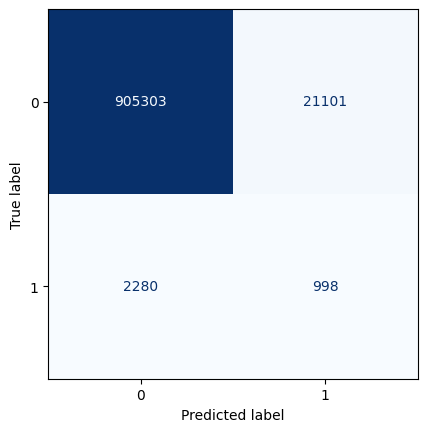

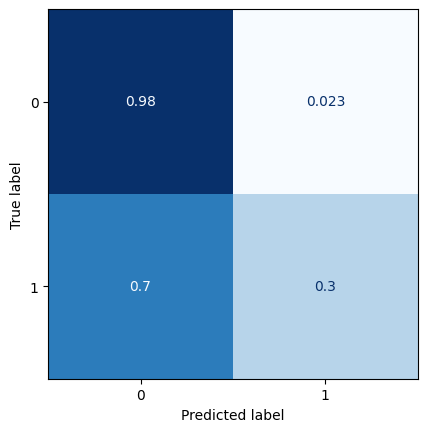

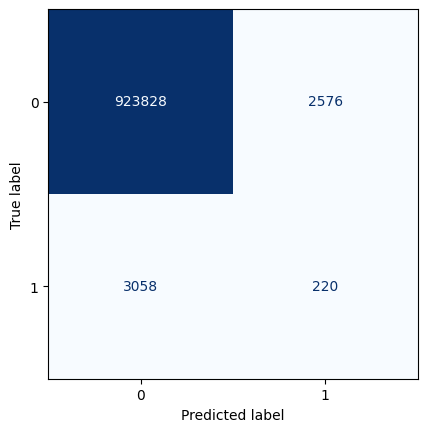

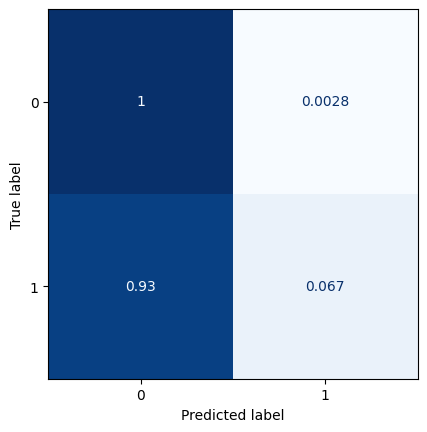

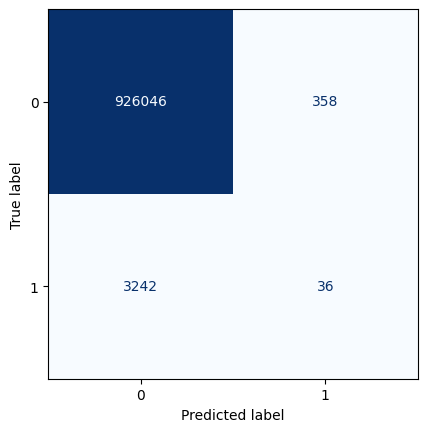

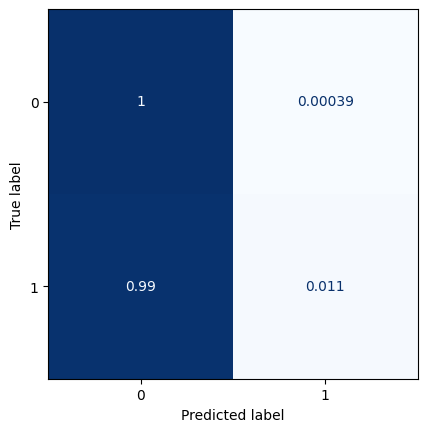

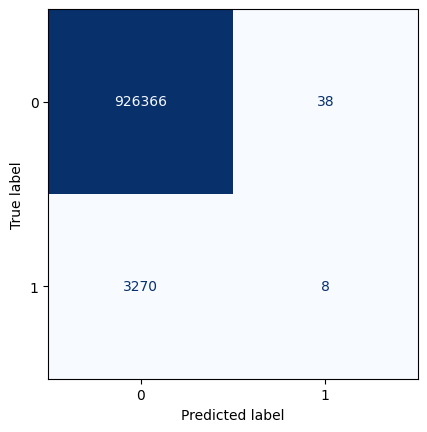

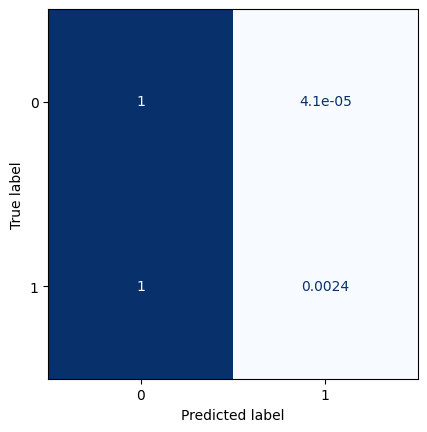

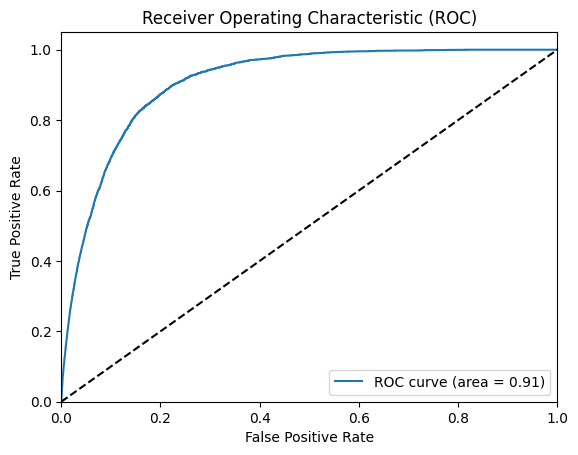

All zeros Brier score: 0.0035259368257102965
Model Brier score: 0.0034452047463369986


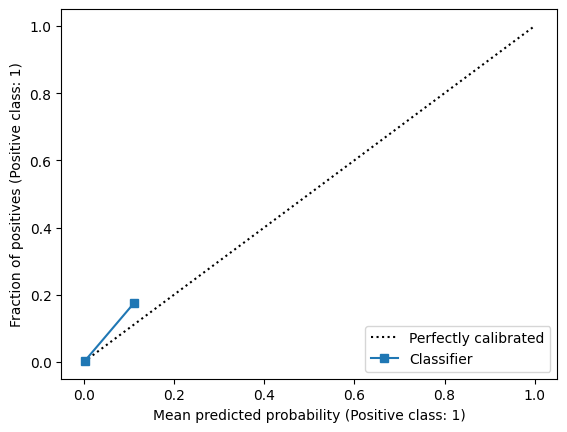

In [85]:
evaluate_perf(t,test_target,day=0)

In [86]:
test = pd.read_csv('/Users/paolo/Documents/TC_old/data/NewData_csv/test_sets_withrealtom.csv')
test = test.loc[test.time>='2016-04-01']
test['predictions_lag0'] = t.reshape(-1,1)
test.to_csv("test_with_newTarget_predictions_CNNglobal.csv")

## Lags from 1 to 13

In [9]:
def Generator(File_address, target_address, year_start, year_end, lag):
    #while True:
    pickle_target = pd.read_pickle(target_address)
    
        #with (open(File_address, "rb")) as openfile: 
        #    while True:
        #        pickle_data.append(pickle.load(openfile))
        #with (open(target_address, "rb")) as openfile: 
        #        pickle_target.append(pickle.load(openfile))
    while True:
        i=0
        for year in range(year_start,year_end+1):
            X = np.load(File_address+'img_'+str(year)+'.npy')
            Y = pickle_target[i+lag:i+X.shape[0]] 
            i += X.shape[0]
            X = X[:-lag,:,:,:-1]
            yield X, Y

In [12]:
x2016 = np.load('/Users/paolo/Documents/TC_old/data/earth_features/test_imgs/2016/img_2016.npy')
x2016 = x2016[91:]
x2017 = np.load('/Users/paolo/Documents/TC_old/data/earth_features/test_imgs/2017/img_2017.npy')
x2018 = np.load('/Users/paolo/Documents/TC_old/data/earth_features/test_imgs/2018/img_2018.npy')
x2019 = np.load('/Users/paolo/Documents/TC_old/data/earth_features/test_imgs/2019/img_2019.npy')
x2020 = np.load('/Users/paolo/Documents/TC_old/data/earth_features/test_imgs/2020/img_2020.npy')
x2021 = np.load('/Users/paolo/Documents/TC_old/data/earth_features/test_imgs/2021/img_2021.npy')
x2022 = np.load('/Users/paolo/Documents/TC_old/data/earth_features/test_imgs/2022/img_2022.npy')
test_target = pd.read_pickle('/Users/paolo/Desktop/TC_world/test_target_img.pkl')


In [13]:
def evaluate_perf(t,test_outputs,day=0):
    one_day_t = t
    one_day_y = test_outputs
    
    ranges = [0.025,0.05,0.075,0.1]
    
    for j in ranges:
        classes = []
        for i in one_day_t.reshape(-1,1):
            if i<=j: classes.append(0)
            else: classes.append(1)
    
    # confusion matrix with threshold on 0.1, otherwise always 0 
        ConfusionMatrixDisplay(confusion_matrix(one_day_y.reshape(-1,1), classes)).plot(colorbar=False,cmap=plt.cm.Blues, values_format='d')
        ConfusionMatrixDisplay(confusion_matrix(one_day_y.reshape(-1,1), classes, normalize='true')).plot(colorbar=False,cmap=plt.cm.Blues)
    
    plot_roc(one_day_t.reshape(-1,1),one_day_y.reshape(-1,1))
    
    display = CalibrationDisplay.from_predictions(one_day_y.reshape(-1,1), one_day_t.reshape(-1,1), n_bins=10)

    print(f'All zeros Brier score: {brier_score_loss(one_day_y.reshape(-1,1), np.zeros(len(one_day_y.reshape(-1,1))))}')
    print(f'Model Brier score: {brier_score_loss(one_day_y.reshape(-1,1), one_day_t.reshape(-1,1))}')
    

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 73, 144, 8)        1808      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 25, 48, 8)        0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 25, 48, 8)         1608      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 9, 16, 8)         0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 9, 16, 8)          1608      
                                                                 
 up_sampling2d_3 (UpSampling  (None, 18, 32, 8)       

2023-06-19 23:38:10.272354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - ETA: 0s - loss: 0.2427

2023-06-19 23:38:19.872494: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 11s 322ms/step - loss: 0.2427 - val_loss: 0.0382
Epoch 2/100
31/31 [==============================] - 9s 275ms/step - loss: 0.0362 - val_loss: 0.0260
Epoch 3/100
31/31 [==============================] - 8s 273ms/step - loss: 0.0285 - val_loss: 0.0251
Epoch 4/100
31/31 [==============================] - 8s 268ms/step - loss: 0.0275 - val_loss: 0.0245
Epoch 5/100
31/31 [==============================] - 8s 270ms/step - loss: 0.0268 - val_loss: 0.0240
Epoch 6/100
31/31 [==============================] - 9s 276ms/step - loss: 0.0263 - val_loss: 0.0236
Epoch 7/100
31/31 [==============================] - 9s 275ms/step - loss: 0.0259 - val_loss: 0.0233
Epoch 8/100
31/31 [==============================] - 8s 268ms/step - loss: 0.0255 - val_loss: 0.0230
Epoch 9/100
31/31 [==============================] - 9s 279ms/step - loss: 0.0252 - val_loss: 0.0227
Epoch 10/100
31/31 [==============================] - 8s 269ms/step - loss: 0.0249 - val_loss: 0.0225


2023-06-19 23:52:20.889925: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 0s 13ms/step


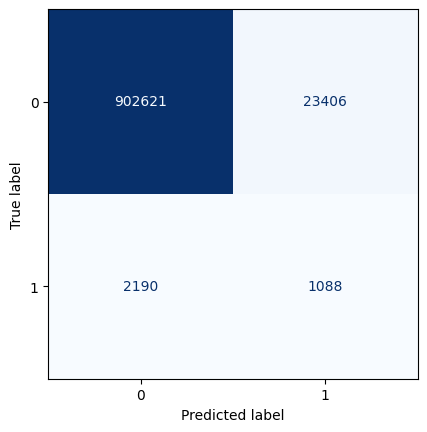

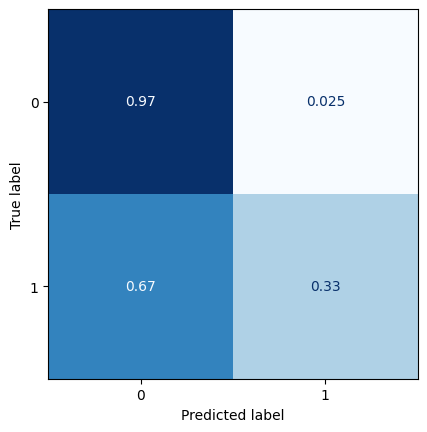

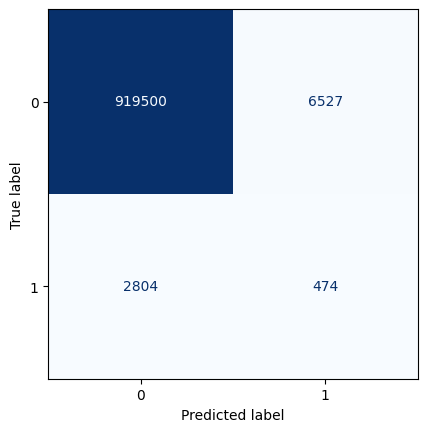

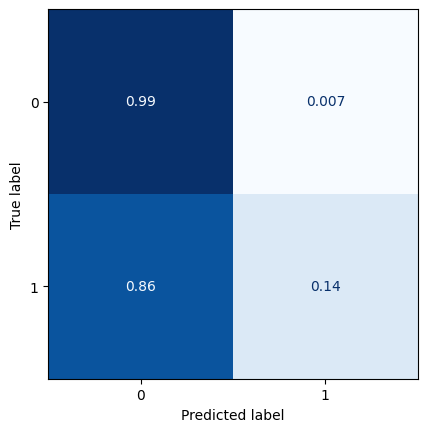

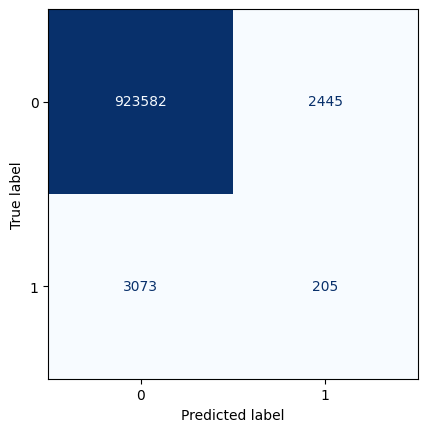

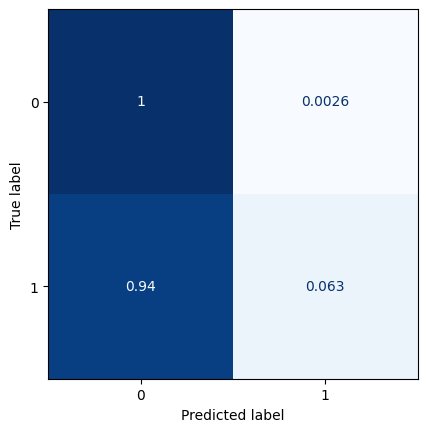

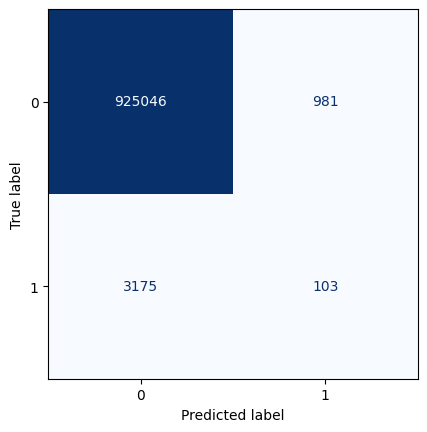

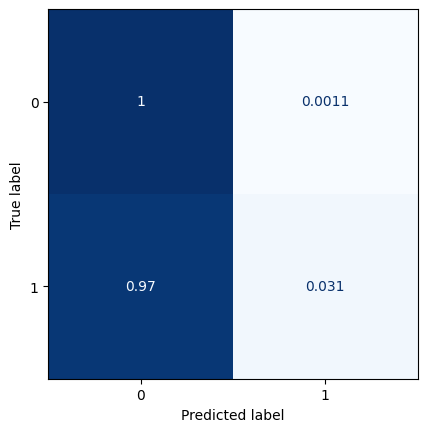

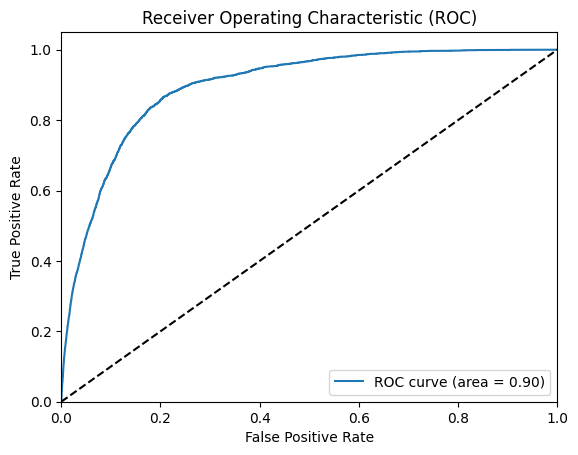

All zeros Brier score: 0.00352736722604527
Model Brier score: 0.003447557772695437
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 73, 144, 8)        1808      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 25, 48, 8)        0         
 2D)                                                             
                                                                 
 conv2d_17 (Conv2D)          (None, 25, 48, 8)         1608      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 9, 16, 8)         0         
 2D)                                                             
                                                                 
 conv2d_18 (Conv2D)          (None, 9, 16, 8)          1608      
                                     

2023-06-19 23:52:44.089194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - ETA: 0s - loss: 0.1034

2023-06-19 23:52:53.184997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 10s 305ms/step - loss: 0.1034 - val_loss: 0.0387
Epoch 2/100
31/31 [==============================] - 9s 280ms/step - loss: 0.0330 - val_loss: 0.0256
Epoch 3/100
31/31 [==============================] - 8s 270ms/step - loss: 0.0271 - val_loss: 0.0240
Epoch 4/100
31/31 [==============================] - 8s 267ms/step - loss: 0.0262 - val_loss: 0.0234
Epoch 5/100
31/31 [==============================] - 8s 269ms/step - loss: 0.0256 - val_loss: 0.0228
Epoch 6/100
31/31 [==============================] - 8s 267ms/step - loss: 0.0250 - val_loss: 0.0224
Epoch 7/100
31/31 [==============================] - 8s 267ms/step - loss: 0.0245 - val_loss: 0.0219
Epoch 8/100
31/31 [==============================] - 8s 268ms/step - loss: 0.0241 - val_loss: 0.0215
Epoch 9/100
31/31 [==============================] - 9s 277ms/step - loss: 0.0237 - val_loss: 0.0212
Epoch 10/100
31/31 [==============================] - 8s 272ms/step - loss: 0.0234 - val_loss: 0.0209


2023-06-20 00:06:55.445198: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 0s 14ms/step


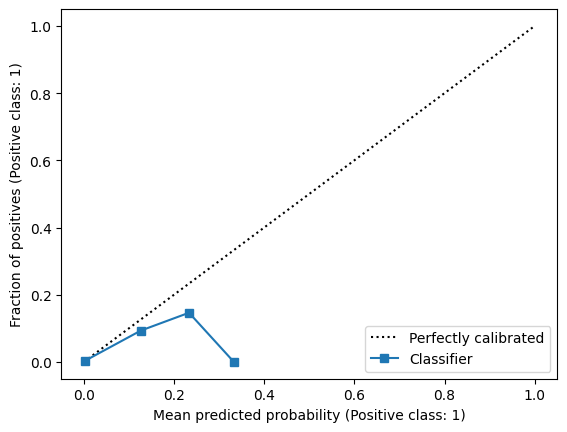

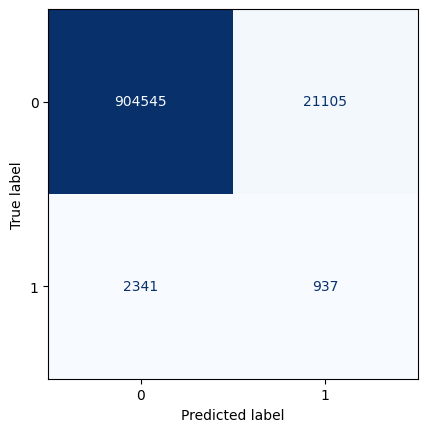

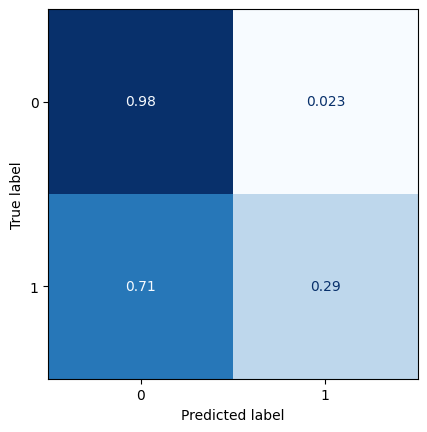

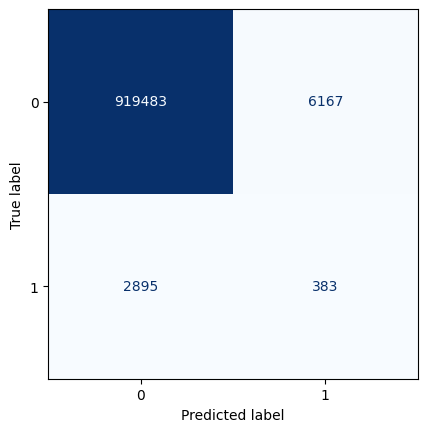

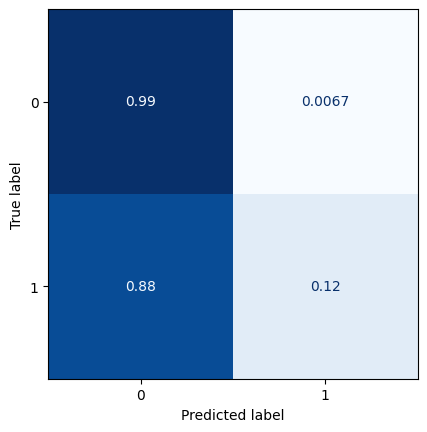

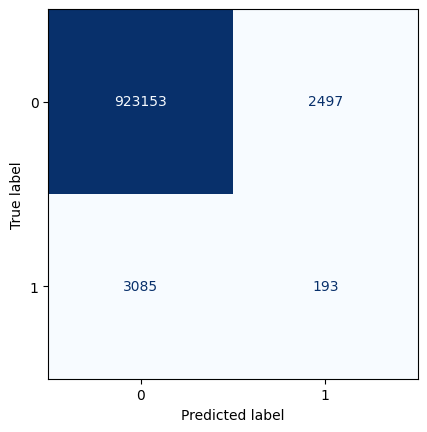

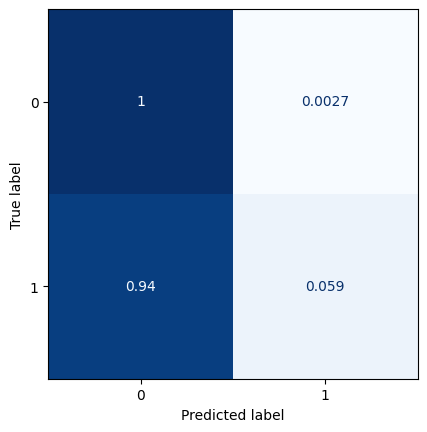

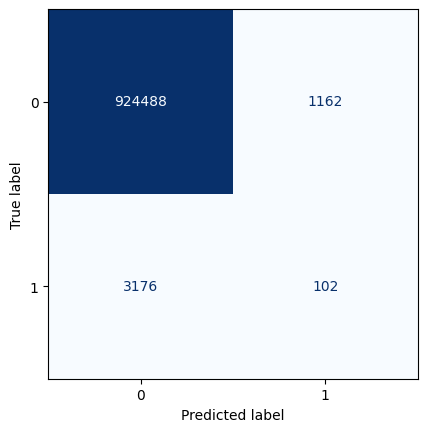

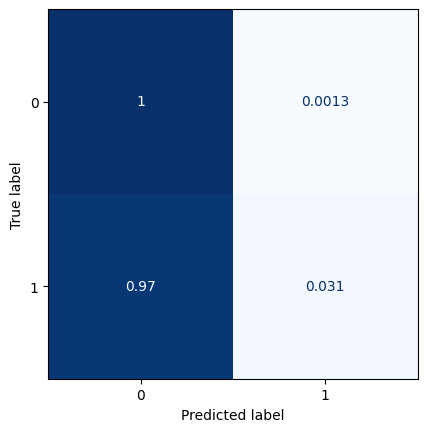

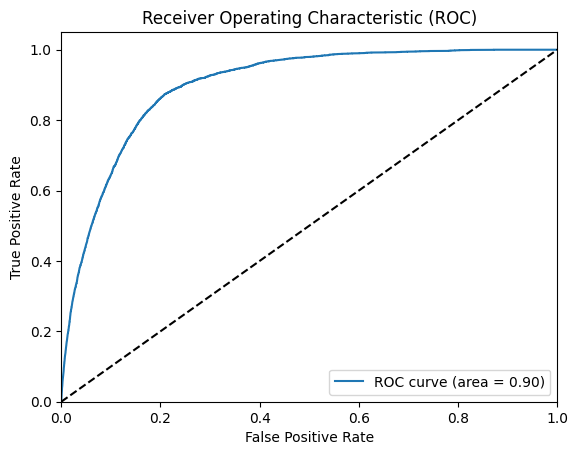

All zeros Brier score: 0.003528798787419477
Model Brier score: 0.003461712138030549
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 73, 144, 8)        1808      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 25, 48, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 25, 48, 8)         1608      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 9, 16, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 9, 16, 8)          1608      
                                    

2023-06-20 00:07:19.677276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - ETA: 0s - loss: 0.1009

2023-06-20 00:07:30.564829: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 13s 384ms/step - loss: 0.1009 - val_loss: 0.0370
Epoch 2/100
31/31 [==============================] - 20s 648ms/step - loss: 0.0309 - val_loss: 0.0240
Epoch 3/100
31/31 [==============================] - 17s 521ms/step - loss: 0.0261 - val_loss: 0.0230
Epoch 4/100
31/31 [==============================] - 10s 313ms/step - loss: 0.0250 - val_loss: 0.0225
Epoch 5/100
31/31 [==============================] - 12s 374ms/step - loss: 0.0245 - val_loss: 0.0219
Epoch 6/100
31/31 [==============================] - 10s 333ms/step - loss: 0.0241 - val_loss: 0.0214
Epoch 7/100
31/31 [==============================] - 9s 274ms/step - loss: 0.0237 - val_loss: 0.0209
Epoch 8/100
31/31 [==============================] - 9s 277ms/step - loss: 0.0233 - val_loss: 0.0206
Epoch 9/100
31/31 [==============================] - 11s 351ms/step - loss: 0.0230 - val_loss: 0.0203
Epoch 10/100
31/31 [==============================] - 13s 430ms/step - loss: 0.0227 - val_loss: 

2023-06-20 00:16:30.686849: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 0s 14ms/step


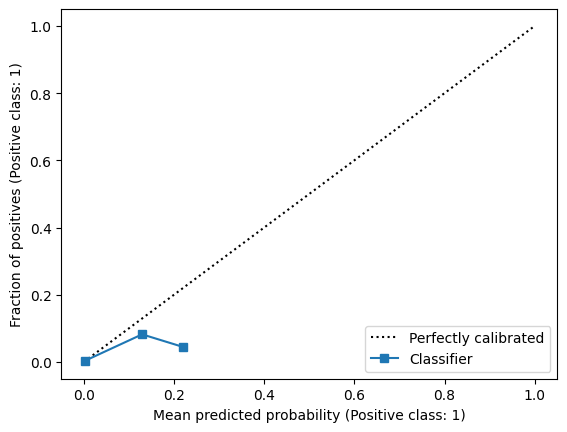

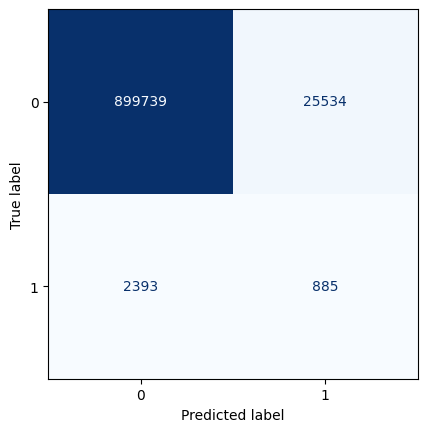

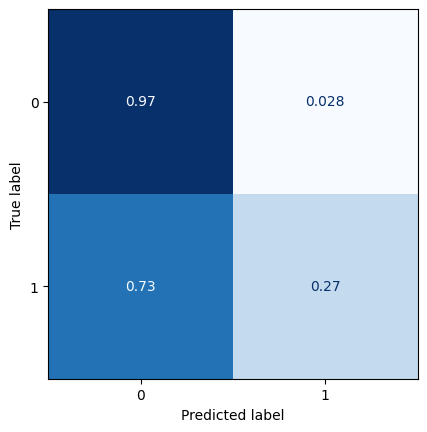

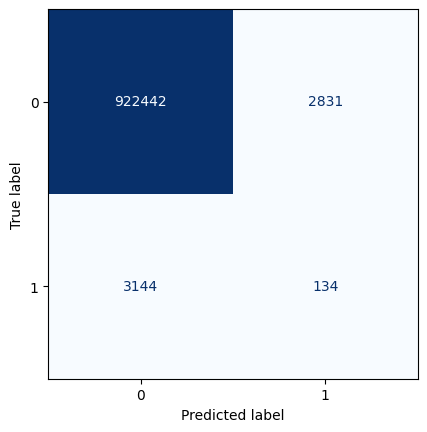

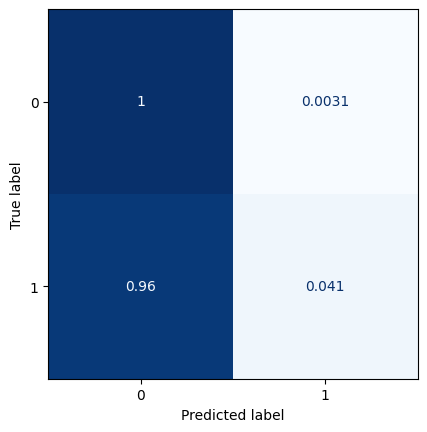

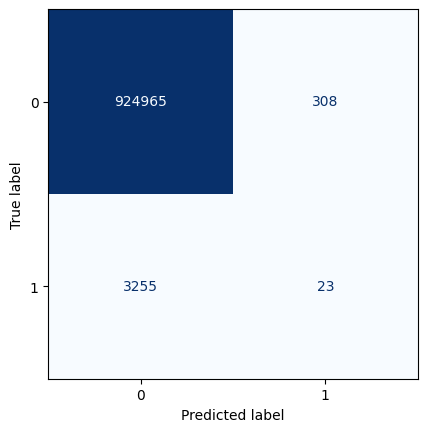

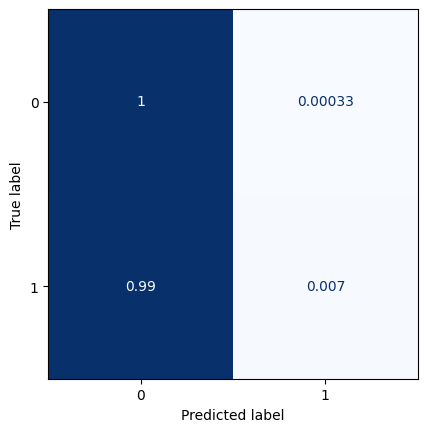

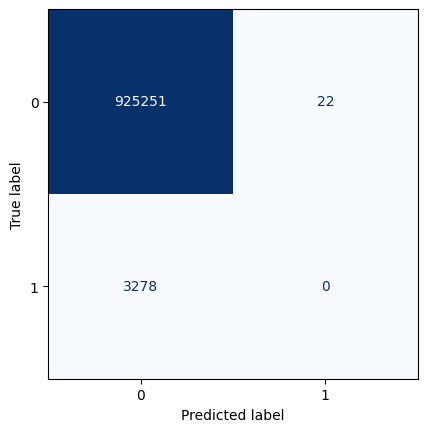

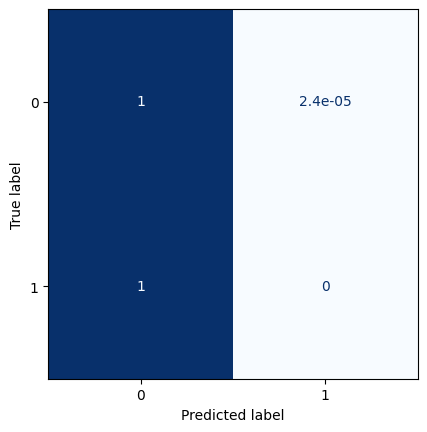

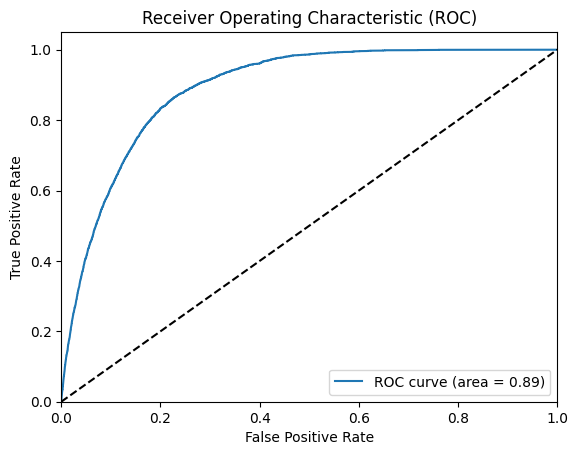

All zeros Brier score: 0.0035302315112470937
Model Brier score: 0.003470196090536014
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 73, 144, 8)        1808      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 25, 48, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 25, 48, 8)         1608      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 9, 16, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 9, 16, 8)          1608      
                                   

2023-06-20 00:17:00.060568: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - ETA: 0s - loss: 0.0938

2023-06-20 00:17:26.485644: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 32s 1s/step - loss: 0.0938 - val_loss: 0.0368
Epoch 2/100
31/31 [==============================] - 19s 591ms/step - loss: 0.0335 - val_loss: 0.0263
Epoch 3/100
31/31 [==============================] - 17s 514ms/step - loss: 0.0284 - val_loss: 0.0243
Epoch 4/100
31/31 [==============================] - 17s 527ms/step - loss: 0.0269 - val_loss: 0.0233
Epoch 5/100
31/31 [==============================] - 15s 481ms/step - loss: 0.0259 - val_loss: 0.0226
Epoch 6/100
31/31 [==============================] - 27s 890ms/step - loss: 0.0251 - val_loss: 0.0220
Epoch 7/100
31/31 [==============================] - 23s 722ms/step - loss: 0.0245 - val_loss: 0.0216
Epoch 8/100
31/31 [==============================] - 13s 390ms/step - loss: 0.0240 - val_loss: 0.0212
Epoch 9/100
31/31 [==============================] - 17s 543ms/step - loss: 0.0236 - val_loss: 0.0209
Epoch 10/100
31/31 [==============================] - 11s 365ms/step - loss: 0.0233 - val_loss: 0

Epoch 81/100
31/31 [==============================] - 18s 575ms/step - loss: 0.0202 - val_loss: 0.0185
Epoch 82/100
31/31 [==============================] - 14s 435ms/step - loss: 0.0202 - val_loss: 0.0185
Epoch 83/100
31/31 [==============================] - 15s 456ms/step - loss: 0.0201 - val_loss: 0.0185
Epoch 84/100
31/31 [==============================] - 15s 463ms/step - loss: 0.0201 - val_loss: 0.0185
Epoch 85/100
31/31 [==============================] - 15s 473ms/step - loss: 0.0201 - val_loss: 0.0185
Epoch 86/100
31/31 [==============================] - 11s 366ms/step - loss: 0.0201 - val_loss: 0.0185
Epoch 87/100
31/31 [==============================] - 15s 483ms/step - loss: 0.0200 - val_loss: 0.0185
Epoch 88/100
31/31 [==============================] - 14s 446ms/step - loss: 0.0200 - val_loss: 0.0185
Epoch 89/100
31/31 [==============================] - 16s 496ms/step - loss: 0.0200 - val_loss: 0.0185
Epoch 90/100
31/31 [==============================] - 11s 362ms/step - lo

2023-06-20 00:46:47.421070: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 0s 13ms/step


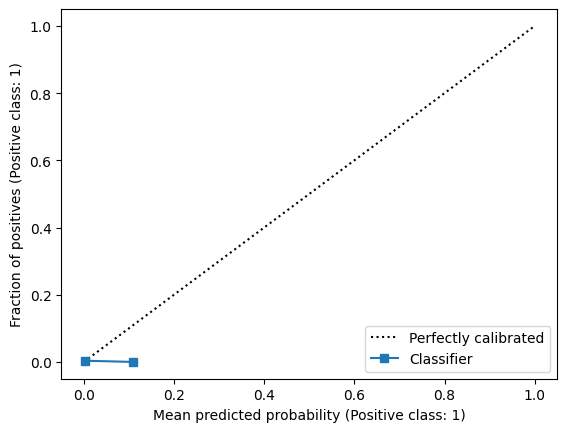

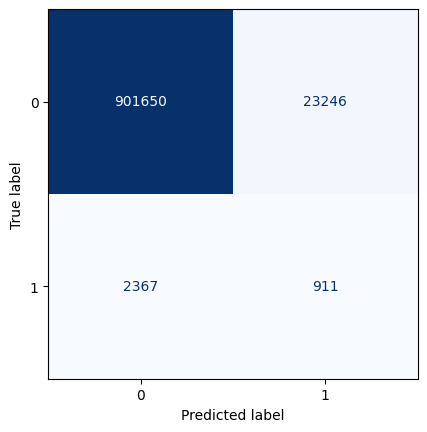

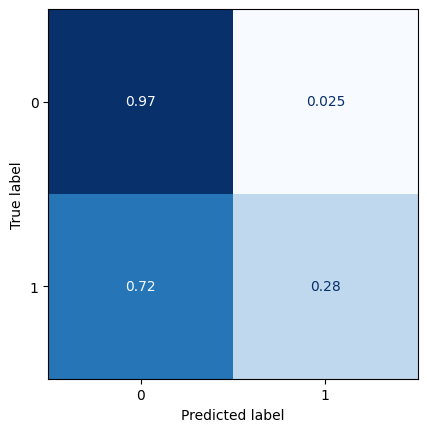

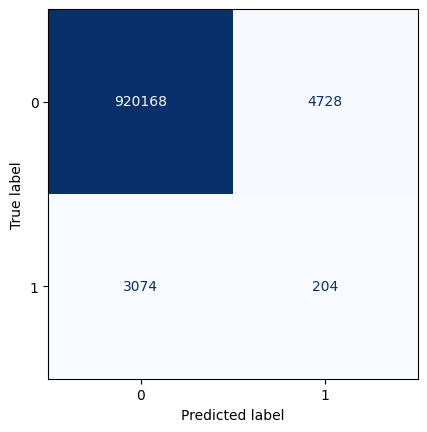

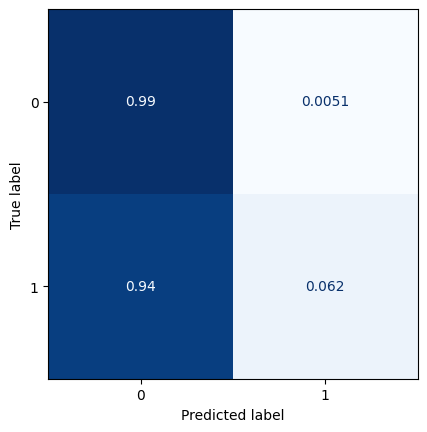

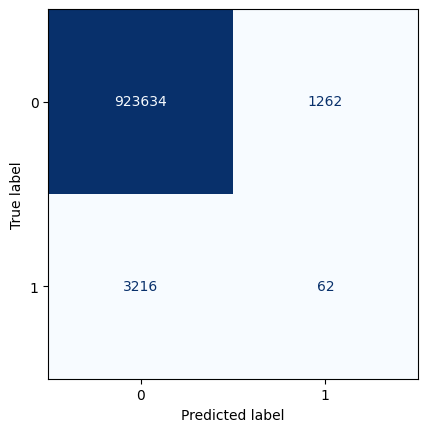

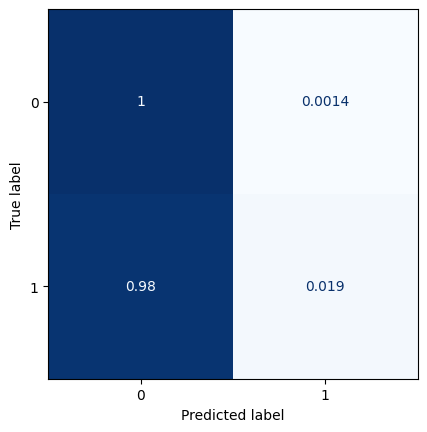

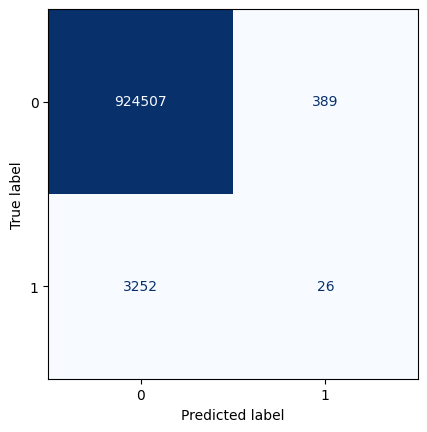

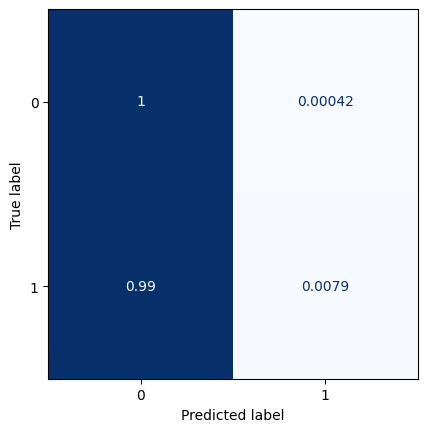

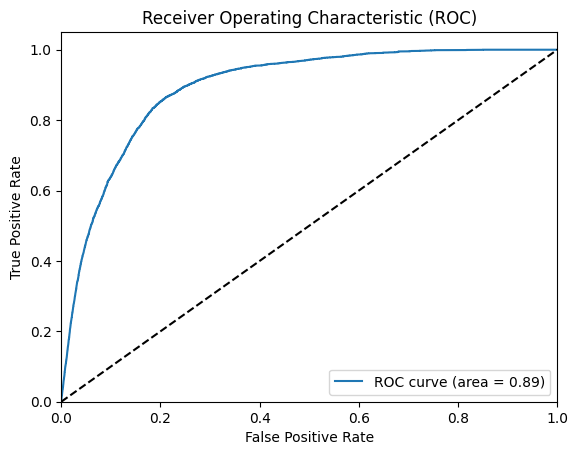

All zeros Brier score: 0.0035316653989445946
Model Brier score: 0.0034712369176950267
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 73, 144, 8)        1808      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 25, 48, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 25, 48, 8)         1608      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 9, 16, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 9, 16, 8)          1608      
                                  

2023-06-20 00:47:20.431772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - ETA: 0s - loss: 0.0848

2023-06-20 00:47:46.853544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 32s 992ms/step - loss: 0.0848 - val_loss: 0.0362
Epoch 2/100
31/31 [==============================] - 18s 533ms/step - loss: 0.0327 - val_loss: 0.0256
Epoch 3/100
31/31 [==============================] - 13s 390ms/step - loss: 0.0282 - val_loss: 0.0241
Epoch 4/100
31/31 [==============================] - 18s 570ms/step - loss: 0.0266 - val_loss: 0.0232
Epoch 5/100
31/31 [==============================] - 14s 435ms/step - loss: 0.0257 - val_loss: 0.0225
Epoch 6/100
31/31 [==============================] - 19s 616ms/step - loss: 0.0249 - val_loss: 0.0219
Epoch 7/100
31/31 [==============================] - 12s 391ms/step - loss: 0.0243 - val_loss: 0.0214
Epoch 8/100
31/31 [==============================] - 18s 565ms/step - loss: 0.0238 - val_loss: 0.0210
Epoch 9/100
31/31 [==============================] - 22s 713ms/step - loss: 0.0234 - val_loss: 0.0207
Epoch 10/100
31/31 [==============================] - 22s 691ms/step - loss: 0.0231 - val_loss

2023-06-20 01:09:20.373778: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 0s 22ms/step


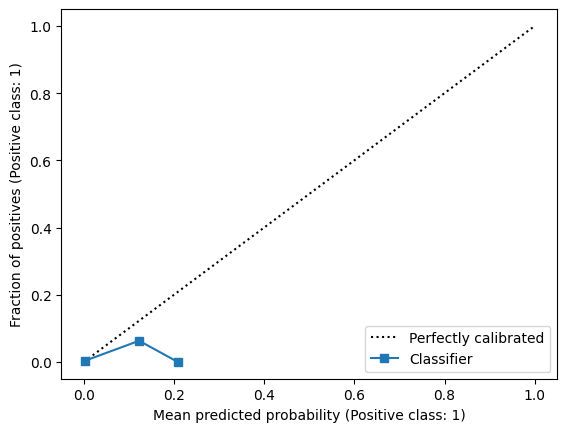

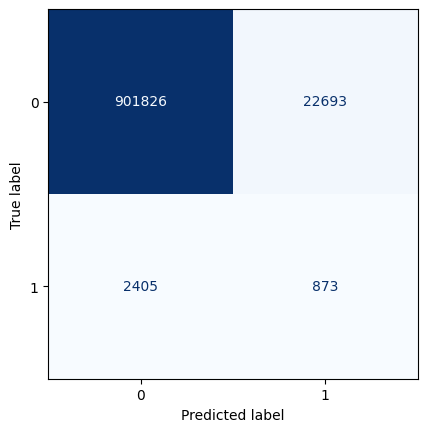

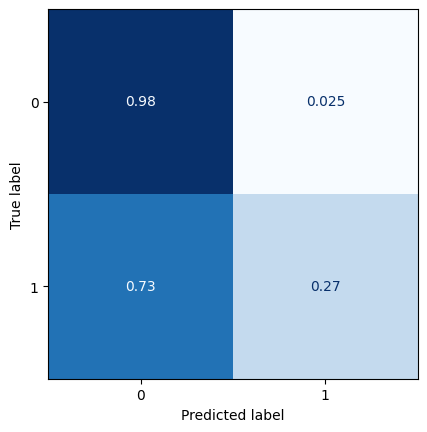

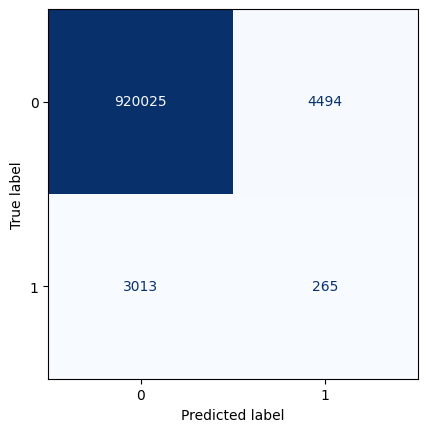

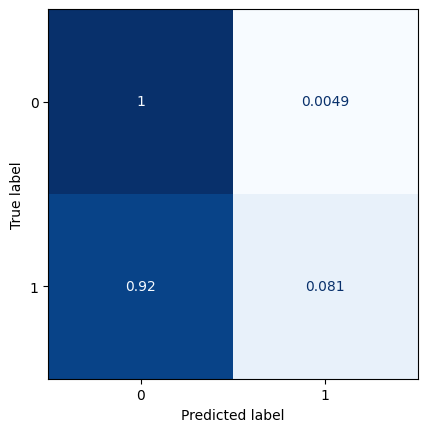

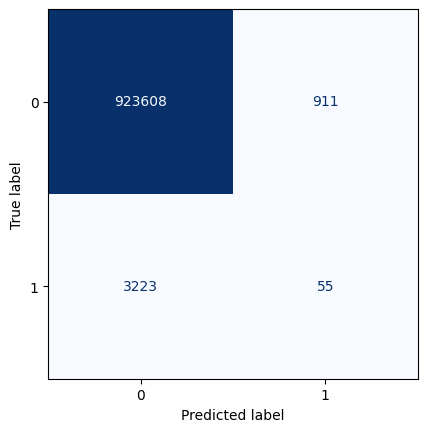

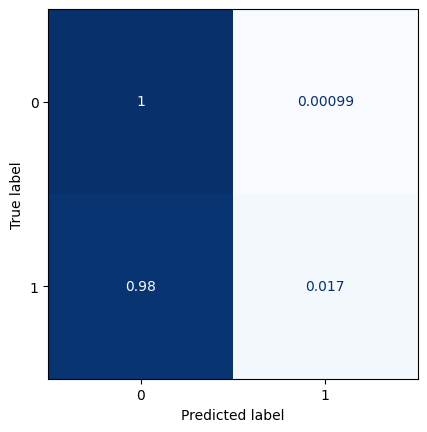

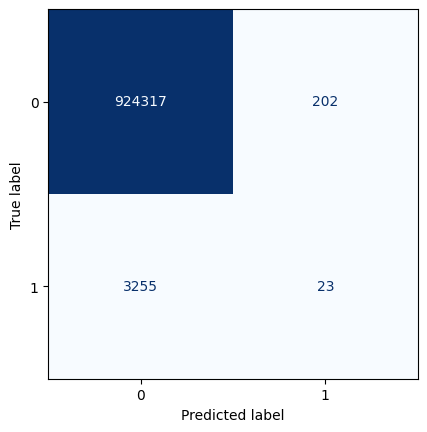

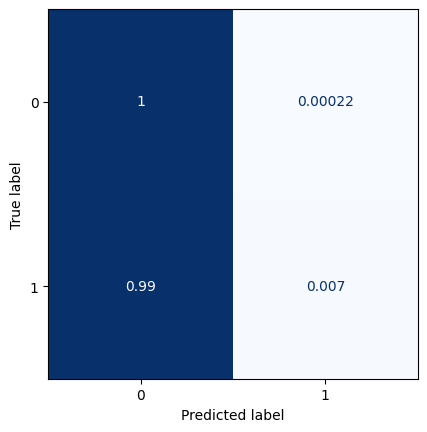

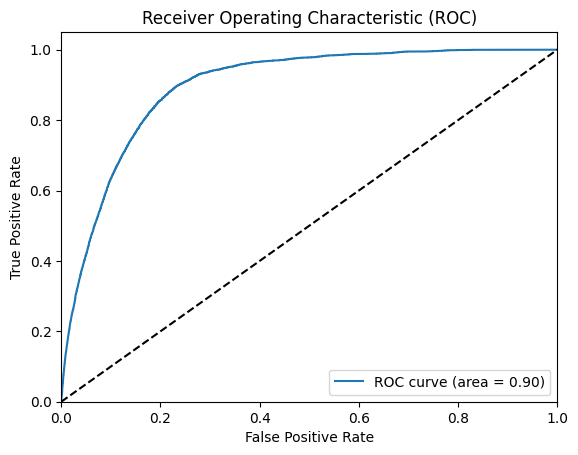

All zeros Brier score: 0.0035331004519307562
Model Brier score: 0.003467981356849272
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 73, 144, 8)        1808      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 25, 48, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 25, 48, 8)         1608      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 9, 16, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 9, 16, 8)          1608      
                                   

2023-06-20 01:09:49.395219: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - ETA: 0s - loss: 0.2677

2023-06-20 01:10:18.295437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 31s 1s/step - loss: 0.2677 - val_loss: 0.0406
Epoch 2/100
31/31 [==============================] - 25s 792ms/step - loss: 0.0418 - val_loss: 0.0263
Epoch 3/100
31/31 [==============================] - 22s 688ms/step - loss: 0.0295 - val_loss: 0.0250
Epoch 4/100
31/31 [==============================] - 13s 420ms/step - loss: 0.0280 - val_loss: 0.0240
Epoch 5/100
31/31 [==============================] - 18s 579ms/step - loss: 0.0269 - val_loss: 0.0232
Epoch 6/100
31/31 [==============================] - 18s 586ms/step - loss: 0.0260 - val_loss: 0.0224
Epoch 7/100
31/31 [==============================] - 14s 432ms/step - loss: 0.0252 - val_loss: 0.0217
Epoch 8/100
31/31 [==============================] - 20s 564ms/step - loss: 0.0245 - val_loss: 0.0211
Epoch 9/100
31/31 [==============================] - 15s 466ms/step - loss: 0.0240 - val_loss: 0.0207
Epoch 10/100
31/31 [==============================] - 15s 484ms/step - loss: 0.0237 - val_loss: 0

Epoch 81/100
31/31 [==============================] - 19s 608ms/step - loss: 0.0204 - val_loss: 0.0185
Epoch 82/100
31/31 [==============================] - 18s 590ms/step - loss: 0.0203 - val_loss: 0.0185
Epoch 83/100
31/31 [==============================] - 21s 670ms/step - loss: 0.0203 - val_loss: 0.0185
Epoch 84/100
31/31 [==============================] - 18s 580ms/step - loss: 0.0202 - val_loss: 0.0185
Epoch 85/100
31/31 [==============================] - 13s 398ms/step - loss: 0.0202 - val_loss: 0.0185
Epoch 86/100
31/31 [==============================] - 18s 577ms/step - loss: 0.0202 - val_loss: 0.0185
Epoch 87/100
31/31 [==============================] - 12s 386ms/step - loss: 0.0201 - val_loss: 0.0185
Epoch 87: early stopping


2023-06-20 01:35:46.729065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 0s 24ms/step


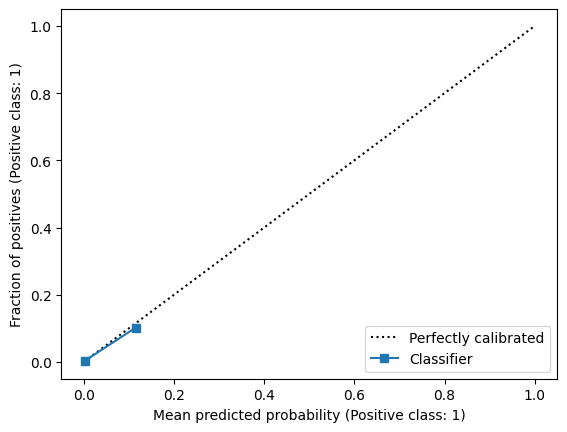

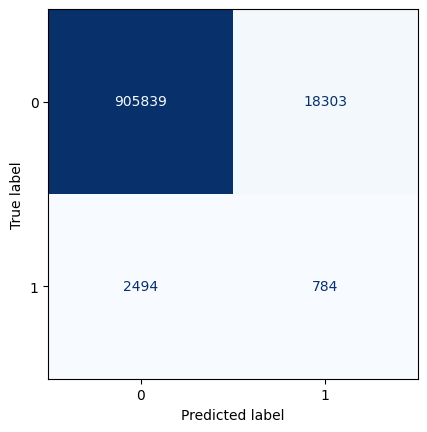

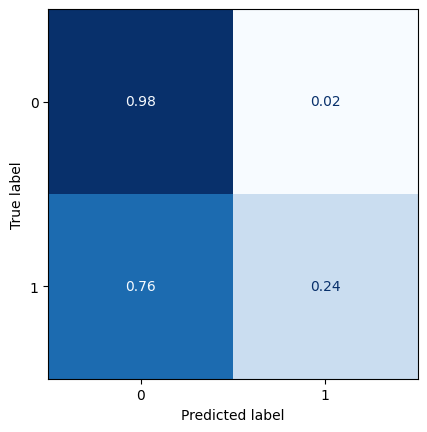

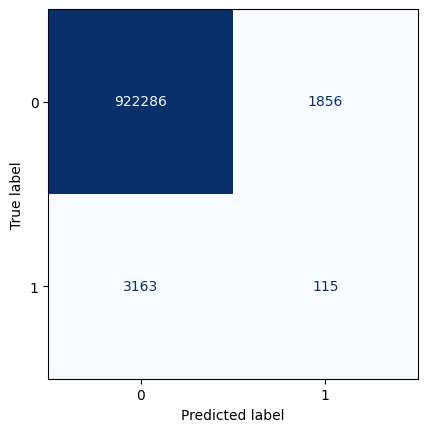

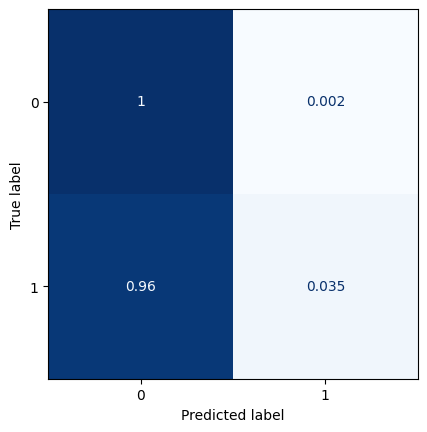

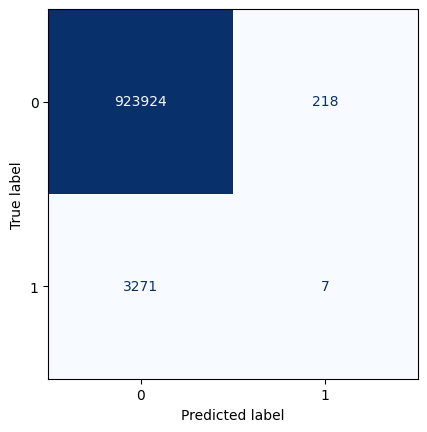

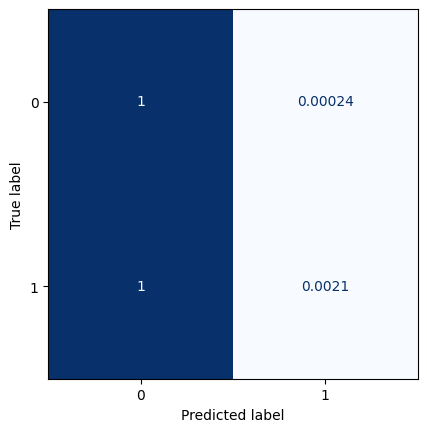

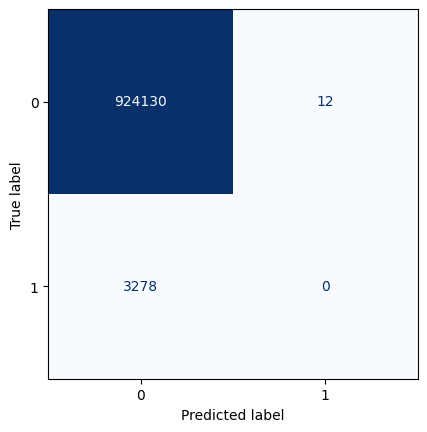

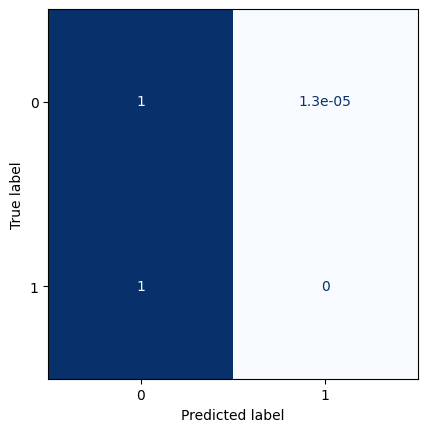

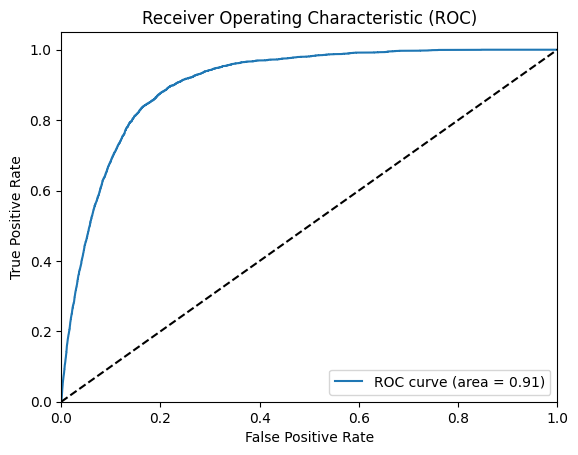

All zeros Brier score: 0.003534536671626663
Model Brier score: 0.0034648278921160175
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 73, 144, 8)        1808      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 25, 48, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 25, 48, 8)         1608      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 9, 16, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 9, 16, 8)          1608      
                                   

2023-06-20 01:36:21.638970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - ETA: 0s - loss: 0.1262

2023-06-20 01:36:49.329867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 32s 1s/step - loss: 0.1262 - val_loss: 0.0413
Epoch 2/100
31/31 [==============================] - 40s 1s/step - loss: 0.0338 - val_loss: 0.0253
Epoch 3/100
31/31 [==============================] - 30s 939ms/step - loss: 0.0273 - val_loss: 0.0236
Epoch 4/100
31/31 [==============================] - 25s 812ms/step - loss: 0.0262 - val_loss: 0.0229
Epoch 5/100
31/31 [==============================] - 29s 912ms/step - loss: 0.0254 - val_loss: 0.0222
Epoch 6/100
31/31 [==============================] - 22s 682ms/step - loss: 0.0248 - val_loss: 0.0216
Epoch 7/100
31/31 [==============================] - 28s 886ms/step - loss: 0.0242 - val_loss: 0.0211
Epoch 8/100
31/31 [==============================] - 21s 633ms/step - loss: 0.0236 - val_loss: 0.0206
Epoch 9/100
31/31 [==============================] - 17s 544ms/step - loss: 0.0231 - val_loss: 0.0202
Epoch 10/100
31/31 [==============================] - 21s 690ms/step - loss: 0.0228 - val_loss: 0.02

2023-06-20 02:01:08.495384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 0s 17ms/step


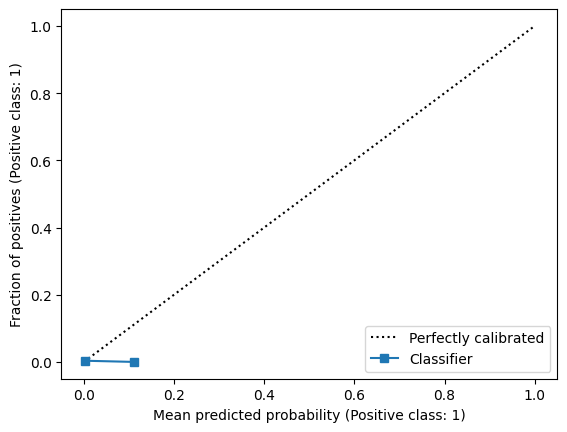

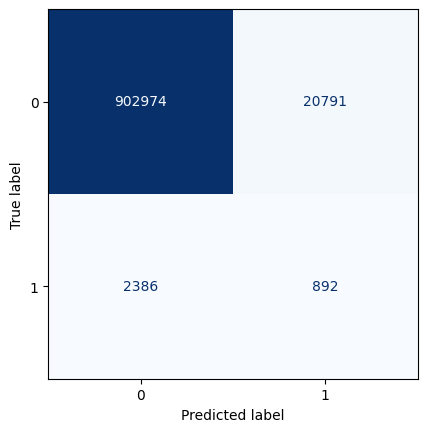

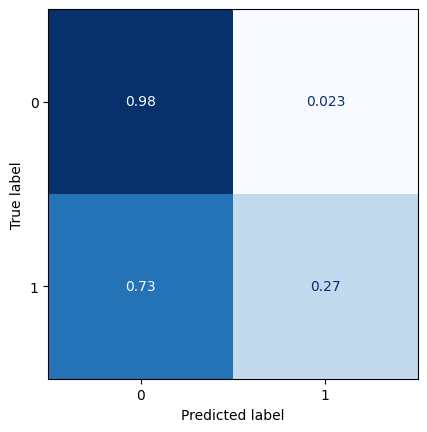

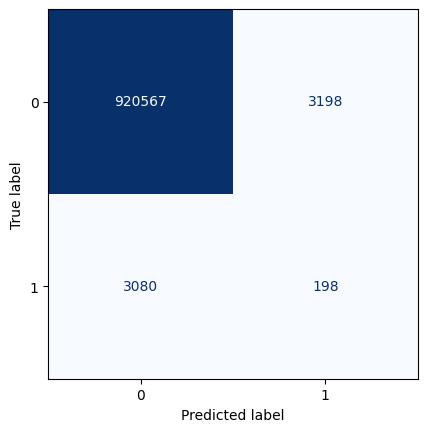

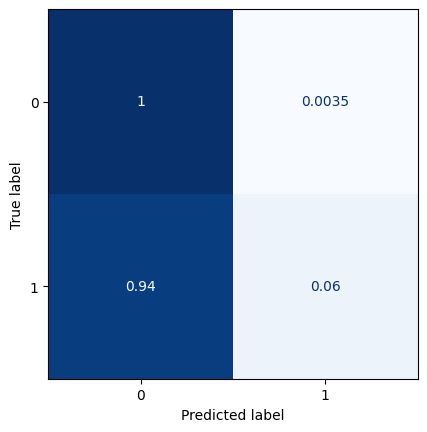

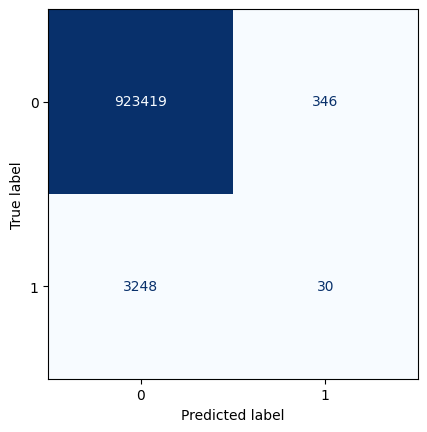

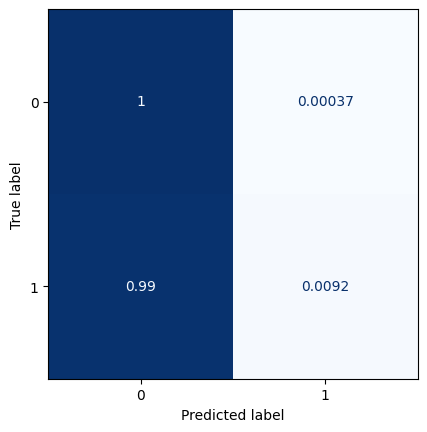

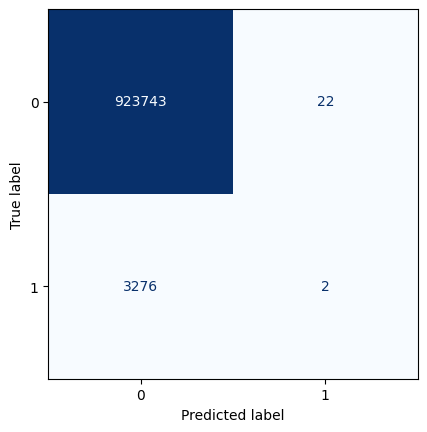

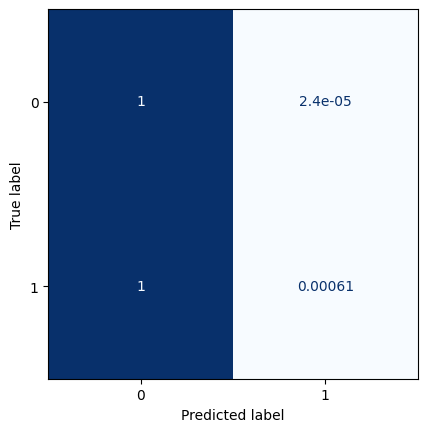

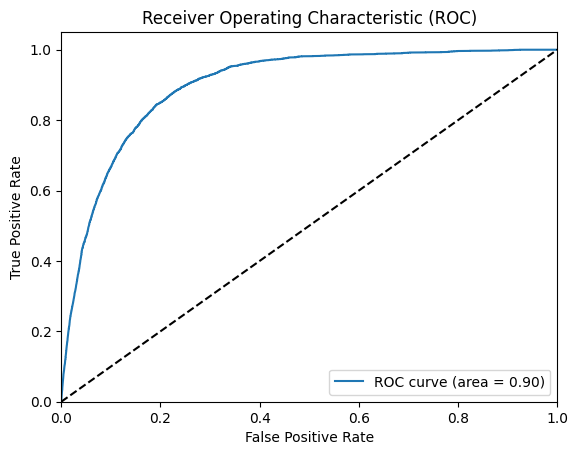

All zeros Brier score: 0.00353597405945571
Model Brier score: 0.003464004045462292
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 73, 144, 8)        1808      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 25, 48, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 25, 48, 8)         1608      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 9, 16, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_42 (Conv2D)          (None, 9, 16, 8)          1608      
                                    

2023-06-20 02:01:48.486675: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - ETA: 0s - loss: 0.0841

2023-06-20 02:02:15.978966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 34s 1s/step - loss: 0.0841 - val_loss: 0.0295
Epoch 2/100
31/31 [==============================] - 28s 786ms/step - loss: 0.0297 - val_loss: 0.0241
Epoch 3/100
31/31 [==============================] - 31s 964ms/step - loss: 0.0266 - val_loss: 0.0229
Epoch 4/100
31/31 [==============================] - 20s 627ms/step - loss: 0.0253 - val_loss: 0.0221
Epoch 5/100
31/31 [==============================] - 16s 504ms/step - loss: 0.0246 - val_loss: 0.0216
Epoch 6/100
31/31 [==============================] - 18s 565ms/step - loss: 0.0241 - val_loss: 0.0212
Epoch 7/100
31/31 [==============================] - 19s 619ms/step - loss: 0.0237 - val_loss: 0.0208
Epoch 8/100
31/31 [==============================] - 23s 732ms/step - loss: 0.0233 - val_loss: 0.0204
Epoch 9/100
31/31 [==============================] - 21s 657ms/step - loss: 0.0231 - val_loss: 0.0202
Epoch 10/100
31/31 [==============================] - 20s 620ms/step - loss: 0.0229 - val_loss: 0

Epoch 81/100
31/31 [==============================] - 18s 599ms/step - loss: 0.0199 - val_loss: 0.0187
Epoch 82/100
31/31 [==============================] - 14s 408ms/step - loss: 0.0199 - val_loss: 0.0187
Epoch 83/100
31/31 [==============================] - 17s 494ms/step - loss: 0.0199 - val_loss: 0.0187
Epoch 84/100
31/31 [==============================] - 13s 413ms/step - loss: 0.0198 - val_loss: 0.0187
Epoch 85/100
31/31 [==============================] - 16s 510ms/step - loss: 0.0198 - val_loss: 0.0187
Epoch 86/100
31/31 [==============================] - 11s 359ms/step - loss: 0.0198 - val_loss: 0.0187
Epoch 87/100
31/31 [==============================] - 18s 589ms/step - loss: 0.0198 - val_loss: 0.0187
Epoch 88/100
31/31 [==============================] - 21s 648ms/step - loss: 0.0198 - val_loss: 0.0187
Epoch 89/100
31/31 [==============================] - 25s 812ms/step - loss: 0.0197 - val_loss: 0.0187
Epoch 90/100
31/31 [==============================] - 21s 680ms/step - lo

2023-06-20 02:29:31.356891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 1s 42ms/step


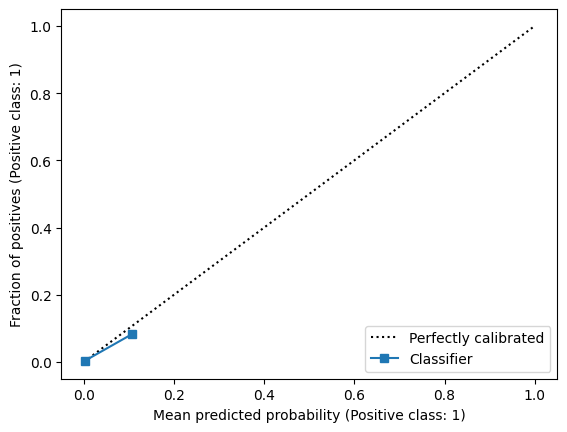

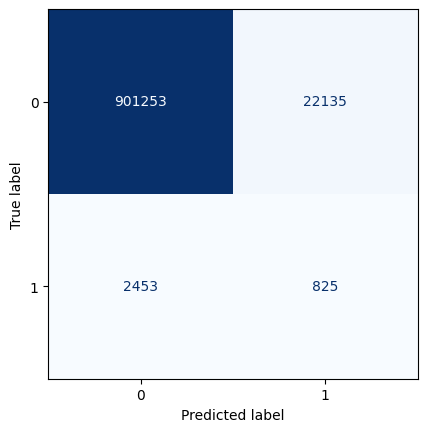

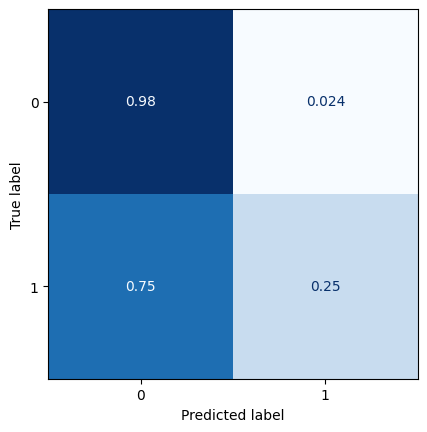

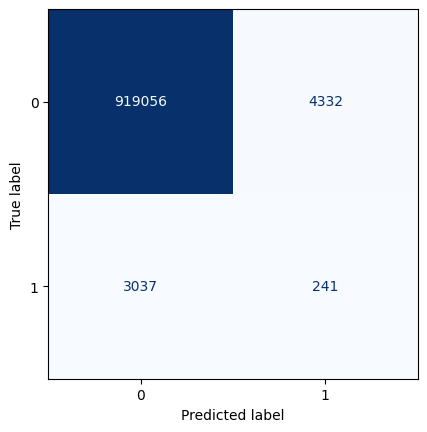

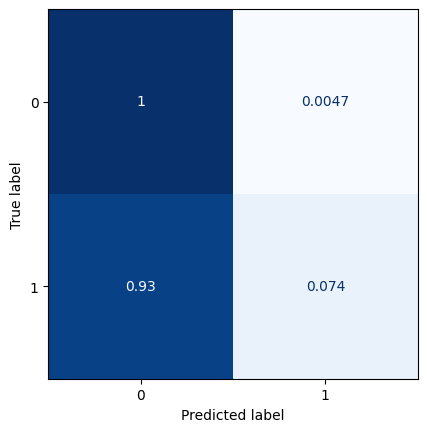

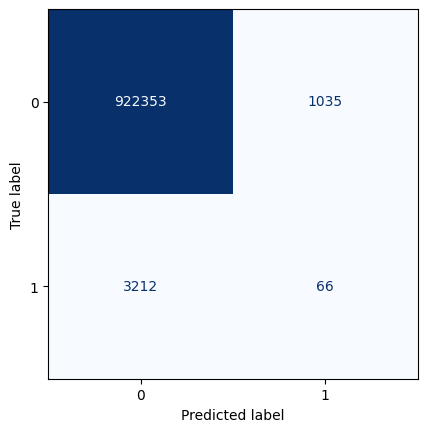

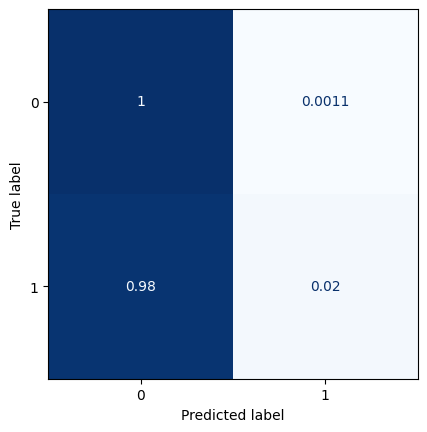

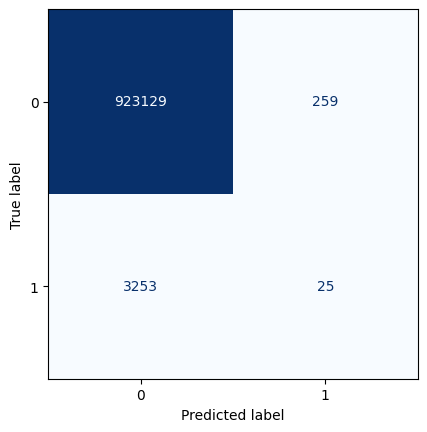

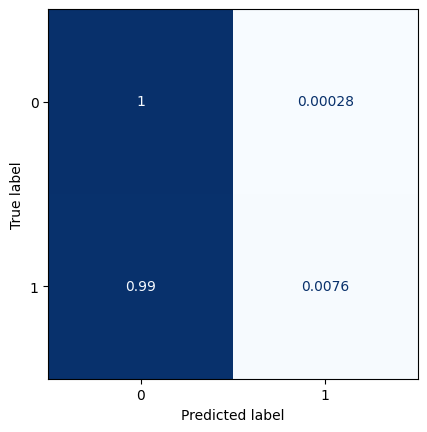

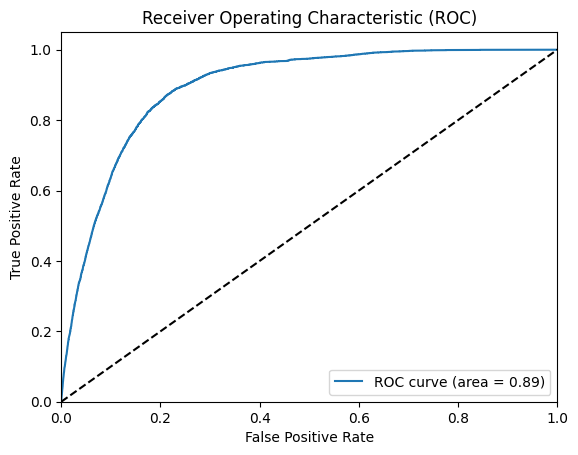

All zeros Brier score: 0.0035374126168436094
Model Brier score: 0.0034749162467494466
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 73, 144, 8)        1808      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 25, 48, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_45 (Conv2D)          (None, 25, 48, 8)         1608      
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 9, 16, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 9, 16, 8)          1608      
                                 

2023-06-20 02:30:13.110961: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - ETA: 0s - loss: 0.0488

2023-06-20 02:30:39.270143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 31s 937ms/step - loss: 0.0488 - val_loss: 0.0271
Epoch 2/100
31/31 [==============================] - 26s 816ms/step - loss: 0.0275 - val_loss: 0.0229
Epoch 3/100
31/31 [==============================] - 26s 817ms/step - loss: 0.0248 - val_loss: 0.0214
Epoch 4/100
31/31 [==============================] - 25s 805ms/step - loss: 0.0237 - val_loss: 0.0206
Epoch 5/100
31/31 [==============================] - 18s 567ms/step - loss: 0.0230 - val_loss: 0.0199
Epoch 6/100
31/31 [==============================] - 13s 414ms/step - loss: 0.0225 - val_loss: 0.0196
Epoch 7/100
31/31 [==============================] - 17s 497ms/step - loss: 0.0222 - val_loss: 0.0194
Epoch 8/100
31/31 [==============================] - 16s 510ms/step - loss: 0.0220 - val_loss: 0.0192
Epoch 9/100
31/31 [==============================] - 19s 601ms/step - loss: 0.0218 - val_loss: 0.0191
Epoch 10/100
31/31 [==============================] - 18s 550ms/step - loss: 0.0216 - val_loss

2023-06-20 02:42:02.777812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 1s 40ms/step


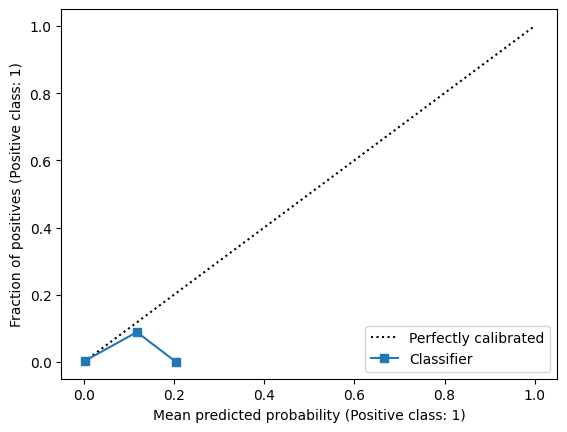

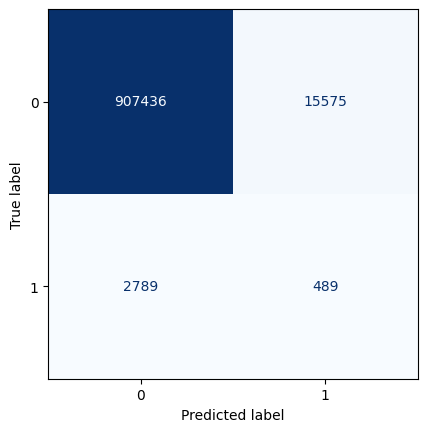

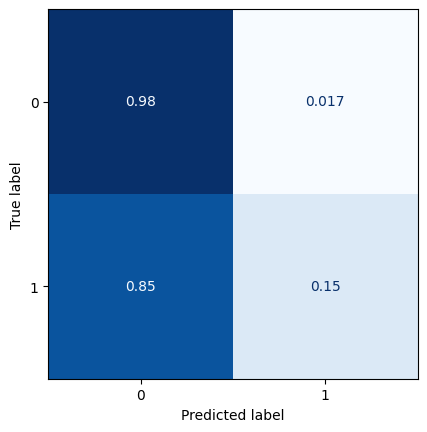

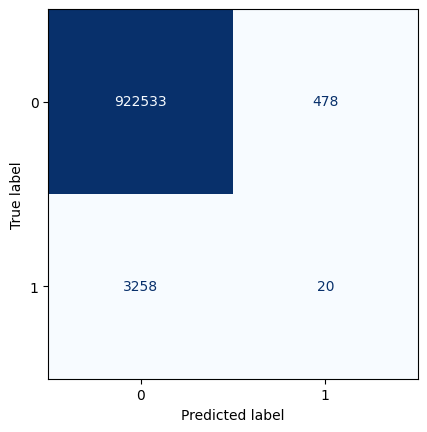

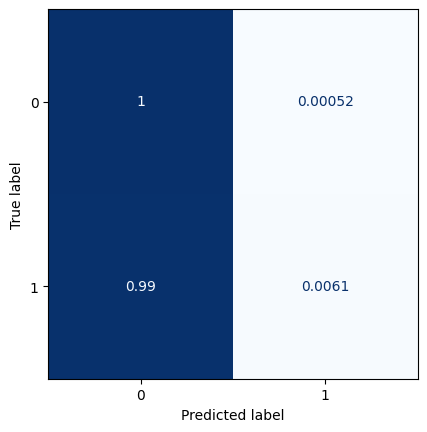

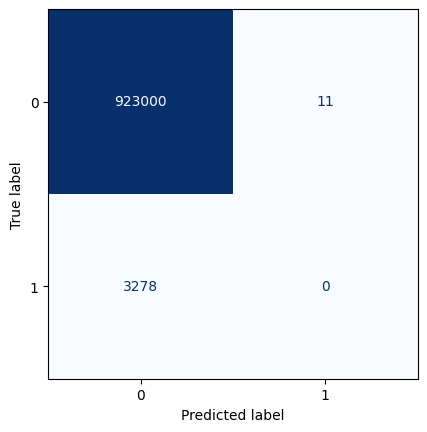

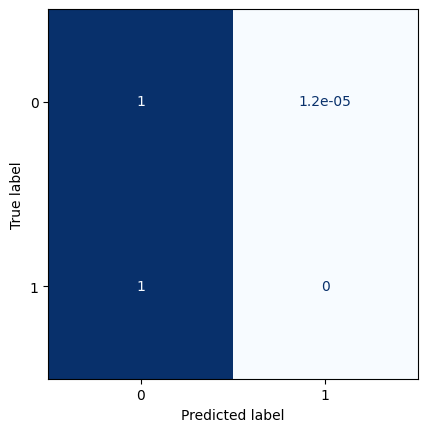

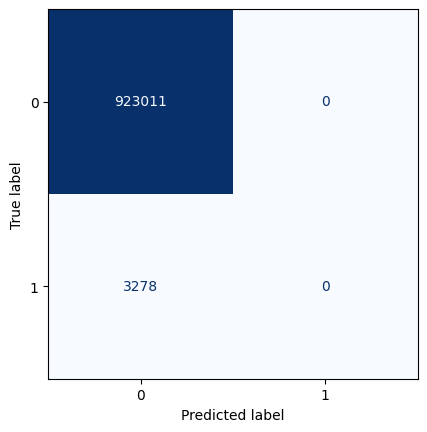

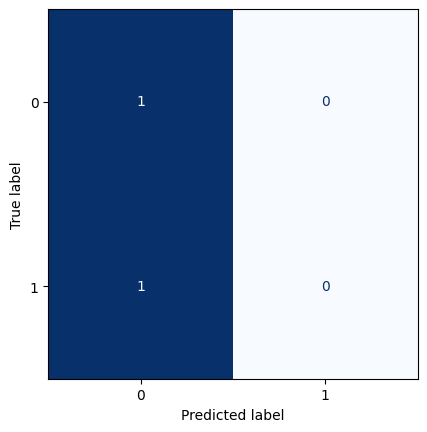

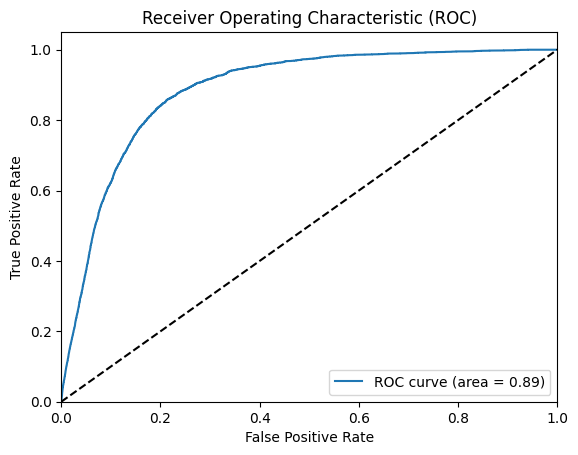

All zeros Brier score: 0.003538852345218393
Model Brier score: 0.003485928443442786
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 73, 144, 8)        1808      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 25, 48, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_49 (Conv2D)          (None, 25, 48, 8)         1608      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 9, 16, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_50 (Conv2D)          (None, 9, 16, 8)          1608      
                                   

2023-06-20 02:42:39.335662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - ETA: 0s - loss: 0.2034

2023-06-20 02:43:11.043385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 40s 1s/step - loss: 0.2034 - val_loss: 0.0351
Epoch 2/100
31/31 [==============================] - 23s 715ms/step - loss: 0.0362 - val_loss: 0.0243
Epoch 3/100
31/31 [==============================] - 27s 846ms/step - loss: 0.0275 - val_loss: 0.0233
Epoch 4/100
31/31 [==============================] - 23s 733ms/step - loss: 0.0263 - val_loss: 0.0226
Epoch 5/100
31/31 [==============================] - 14s 449ms/step - loss: 0.0252 - val_loss: 0.0220
Epoch 6/100
31/31 [==============================] - 19s 612ms/step - loss: 0.0245 - val_loss: 0.0216
Epoch 7/100
31/31 [==============================] - 27s 870ms/step - loss: 0.0241 - val_loss: 0.0213
Epoch 8/100
31/31 [==============================] - 21s 674ms/step - loss: 0.0237 - val_loss: 0.0209
Epoch 9/100
31/31 [==============================] - 14s 449ms/step - loss: 0.0233 - val_loss: 0.0205
Epoch 10/100
31/31 [==============================] - 21s 680ms/step - loss: 0.0230 - val_loss: 0

Epoch 81/100
31/31 [==============================] - 23s 755ms/step - loss: 0.0203 - val_loss: 0.0185
Epoch 81: early stopping


2023-06-20 03:09:13.856124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 1s 53ms/step


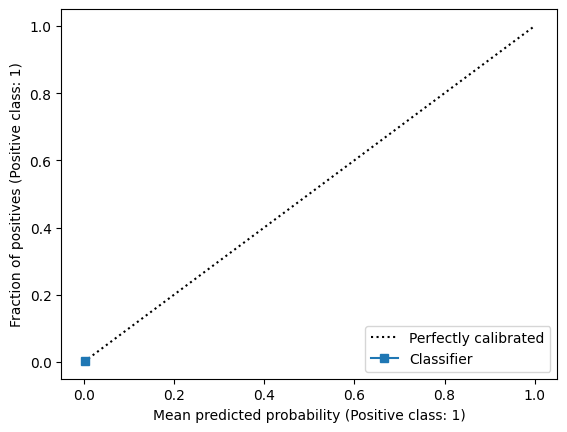

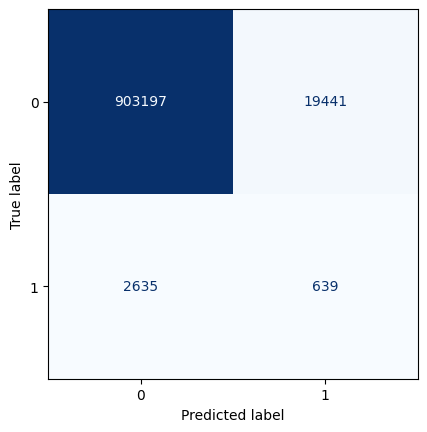

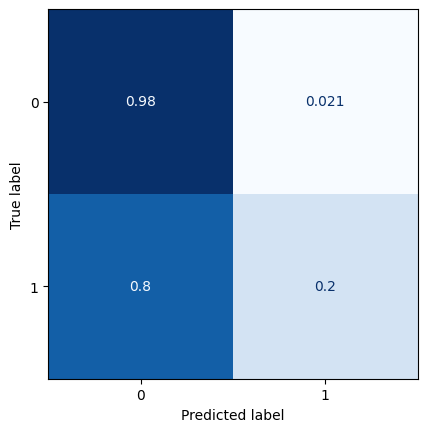

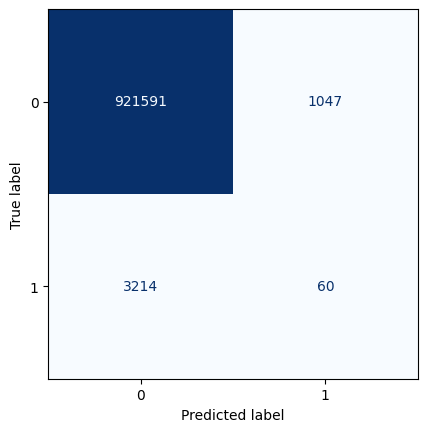

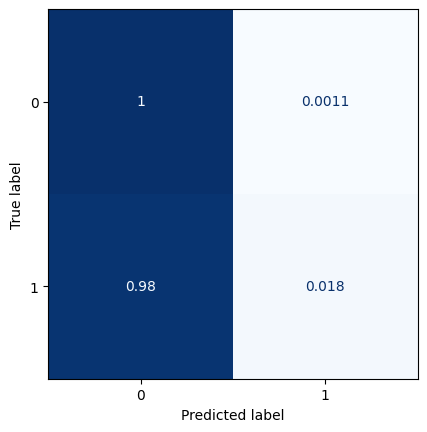

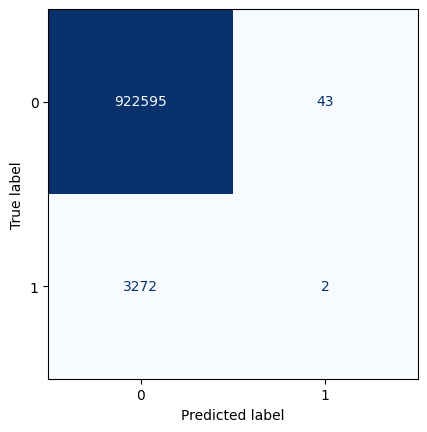

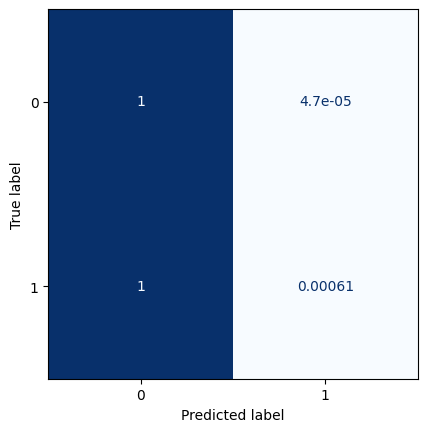

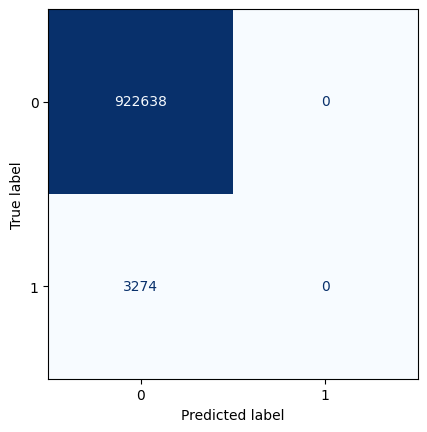

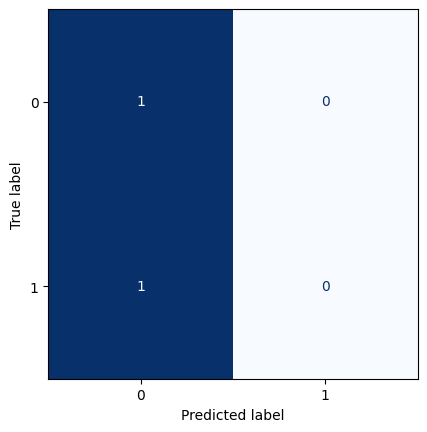

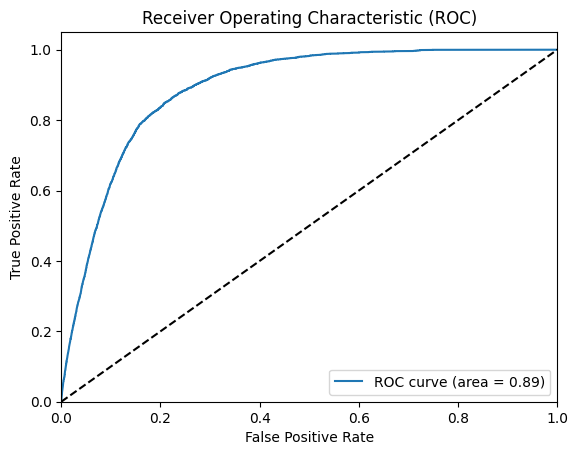

All zeros Brier score: 0.0035359731810366427
Model Brier score: 0.0034789587754903454
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 73, 144, 8)        1808      
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 25, 48, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_53 (Conv2D)          (None, 25, 48, 8)         1608      
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 9, 16, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_54 (Conv2D)          (None, 9, 16, 8)          1608      
                                 

2023-06-20 03:10:03.609950: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - ETA: 0s - loss: 0.3393

2023-06-20 03:10:34.005627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 46s 1s/step - loss: 0.3393 - val_loss: 0.0280
Epoch 2/100
31/31 [==============================] - 21s 651ms/step - loss: 0.0333 - val_loss: 0.0260
Epoch 3/100
31/31 [==============================] - 21s 629ms/step - loss: 0.0276 - val_loss: 0.0240
Epoch 4/100
31/31 [==============================] - 18s 567ms/step - loss: 0.0264 - val_loss: 0.0234
Epoch 5/100
31/31 [==============================] - 21s 681ms/step - loss: 0.0260 - val_loss: 0.0230
Epoch 6/100
31/31 [==============================] - 14s 426ms/step - loss: 0.0256 - val_loss: 0.0226
Epoch 7/100
31/31 [==============================] - 12s 370ms/step - loss: 0.0252 - val_loss: 0.0223
Epoch 8/100
31/31 [==============================] - 16s 524ms/step - loss: 0.0249 - val_loss: 0.0220
Epoch 9/100
31/31 [==============================] - 14s 450ms/step - loss: 0.0246 - val_loss: 0.0217
Epoch 10/100
31/31 [==============================] - 13s 417ms/step - loss: 0.0243 - val_loss: 0

Epoch 81/100
31/31 [==============================] - 18s 577ms/step - loss: 0.0204 - val_loss: 0.0185
Epoch 82/100
31/31 [==============================] - 21s 682ms/step - loss: 0.0204 - val_loss: 0.0185
Epoch 83/100
31/31 [==============================] - 24s 754ms/step - loss: 0.0204 - val_loss: 0.0185
Epoch 84/100
31/31 [==============================] - 23s 736ms/step - loss: 0.0204 - val_loss: 0.0185
Epoch 85/100
31/31 [==============================] - 15s 469ms/step - loss: 0.0204 - val_loss: 0.0185
Epoch 86/100
31/31 [==============================] - 19s 612ms/step - loss: 0.0204 - val_loss: 0.0185
Epoch 87/100
31/31 [==============================] - 25s 785ms/step - loss: 0.0203 - val_loss: 0.0185
Epoch 88/100
31/31 [==============================] - 20s 616ms/step - loss: 0.0203 - val_loss: 0.0185
Epoch 89/100
31/31 [==============================] - 17s 551ms/step - loss: 0.0203 - val_loss: 0.0185
Epoch 90/100
31/31 [==============================] - 18s 577ms/step - lo

2023-06-20 03:36:42.363366: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 1s 46ms/step


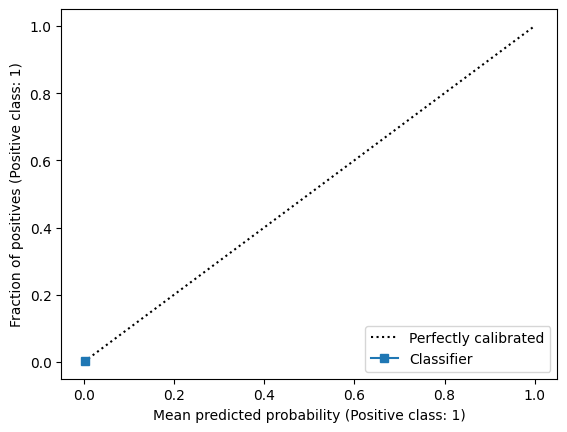

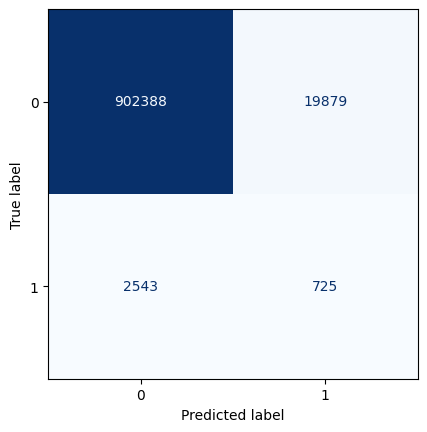

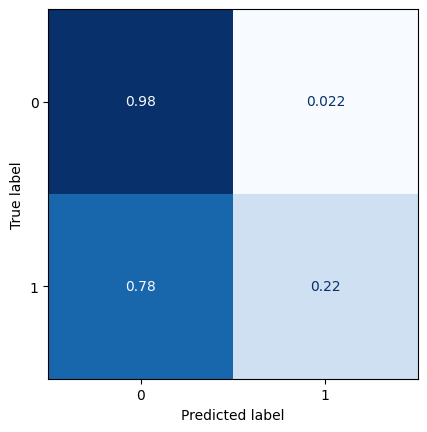

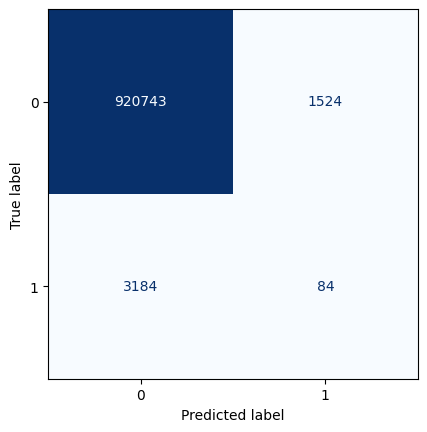

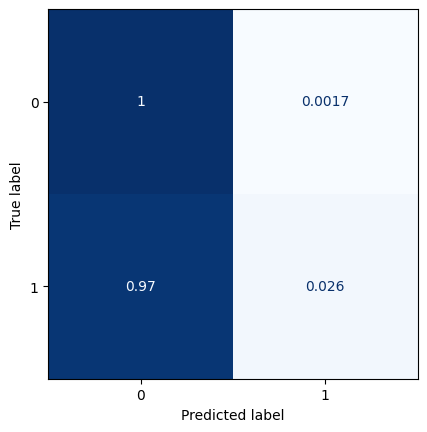

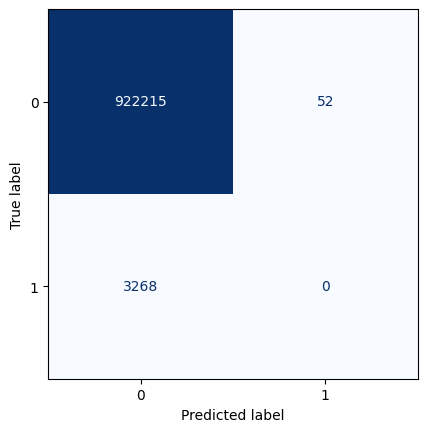

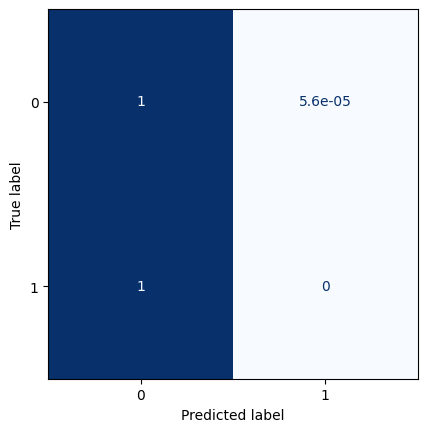

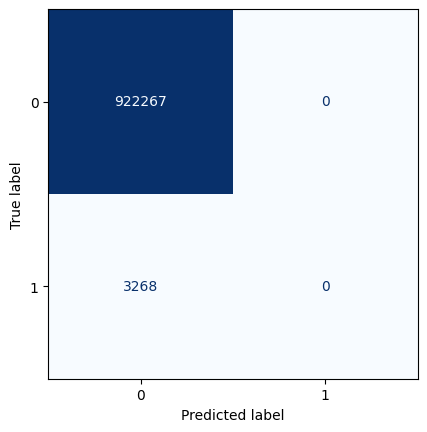

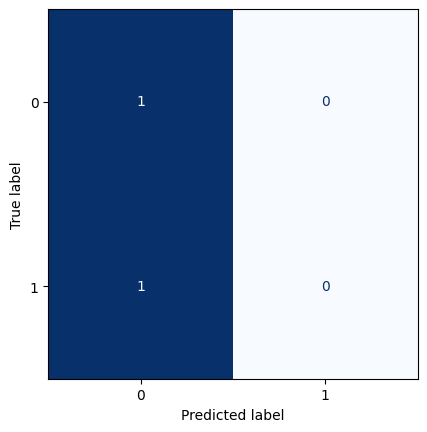

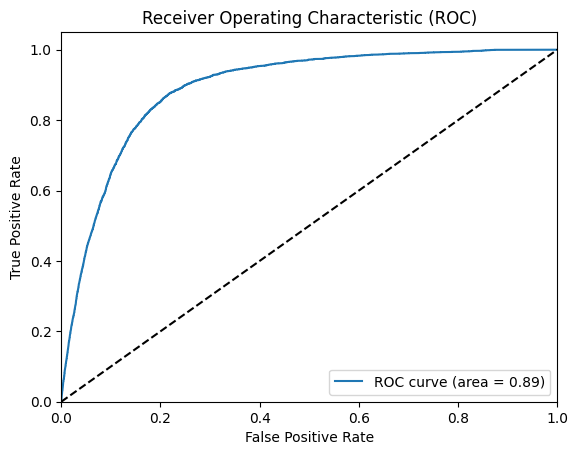

All zeros Brier score: 0.0035309307589664355
Model Brier score: 0.00346964145980669
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_56 (Conv2D)          (None, 73, 144, 8)        1808      
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 25, 48, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_57 (Conv2D)          (None, 25, 48, 8)         1608      
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 9, 16, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_58 (Conv2D)          (None, 9, 16, 8)          1608      
                                   

2023-06-20 03:37:20.835989: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - ETA: 0s - loss: 0.0372

2023-06-20 03:37:54.549216: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 42s 1s/step - loss: 0.0372 - val_loss: 0.0242
Epoch 2/100
31/31 [==============================] - 20s 639ms/step - loss: 0.0248 - val_loss: 0.0210
Epoch 3/100
31/31 [==============================] - 22s 716ms/step - loss: 0.0231 - val_loss: 0.0202
Epoch 4/100
31/31 [==============================] - 27s 867ms/step - loss: 0.0224 - val_loss: 0.0198
Epoch 5/100
31/31 [==============================] - 15s 450ms/step - loss: 0.0221 - val_loss: 0.0194
Epoch 6/100
31/31 [==============================] - 15s 475ms/step - loss: 0.0218 - val_loss: 0.0192
Epoch 7/100
31/31 [==============================] - 23s 737ms/step - loss: 0.0216 - val_loss: 0.0191
Epoch 8/100
31/31 [==============================] - 18s 577ms/step - loss: 0.0214 - val_loss: 0.0190
Epoch 9/100
31/31 [==============================] - 21s 671ms/step - loss: 0.0213 - val_loss: 0.0189
Epoch 10/100
31/31 [==============================] - 17s 539ms/step - loss: 0.0212 - val_loss: 0

2023-06-20 03:53:22.709109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 1s 67ms/step


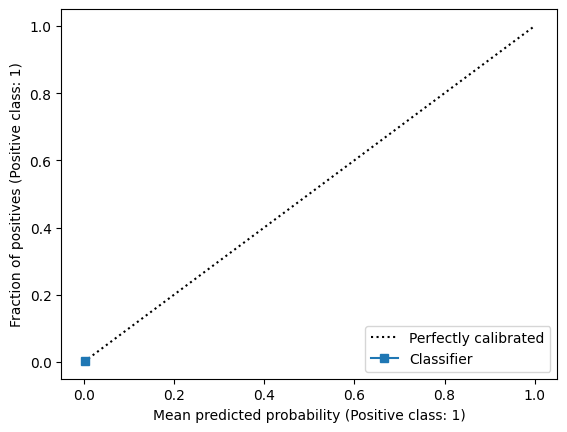

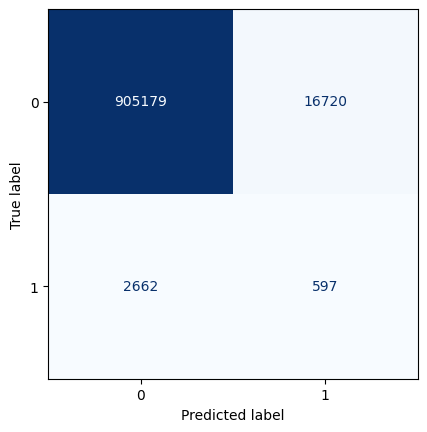

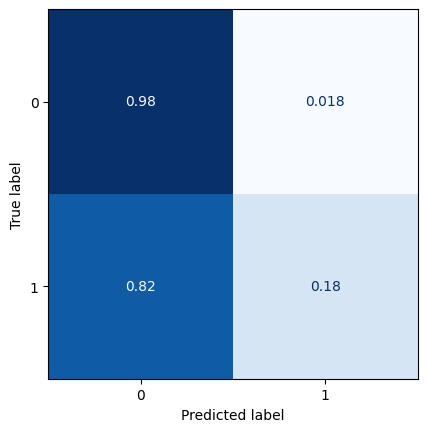

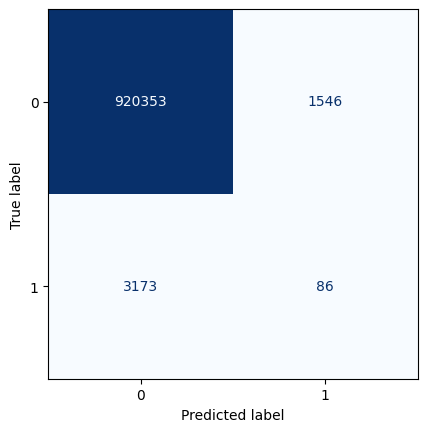

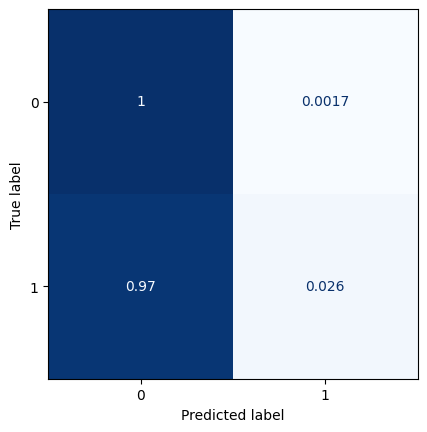

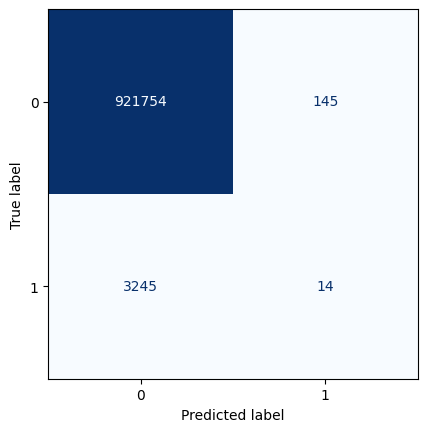

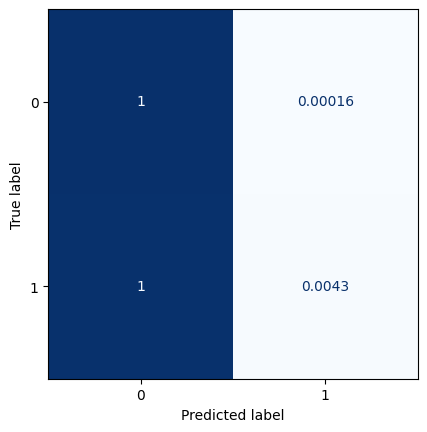

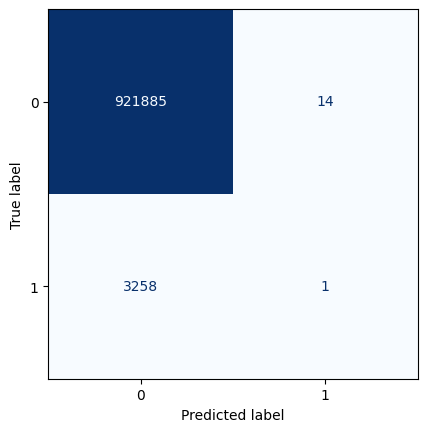

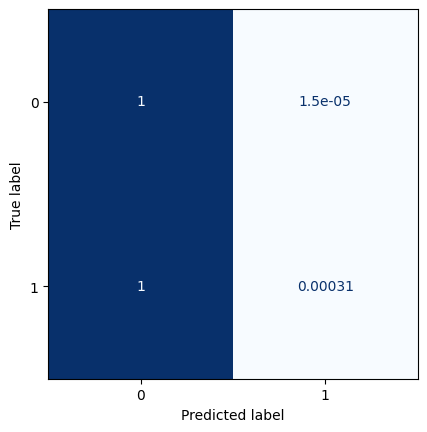

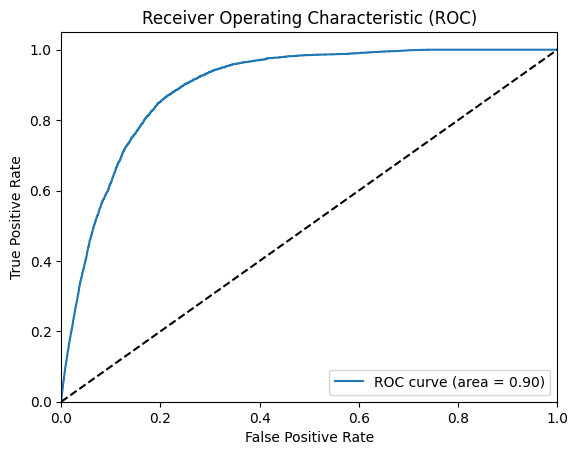

All zeros Brier score: 0.003522641537985944
Model Brier score: 0.0034642659262920047
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 73, 144, 8)        1808      
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 25, 48, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_61 (Conv2D)          (None, 25, 48, 8)         1608      
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 9, 16, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_62 (Conv2D)          (None, 9, 16, 8)          1608      
                                  

2023-06-20 03:54:06.948188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - ETA: 0s - loss: 0.0862

2023-06-20 03:54:38.742700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 37s 1s/step - loss: 0.0862 - val_loss: 0.0344
Epoch 2/100
31/31 [==============================] - 30s 947ms/step - loss: 0.0320 - val_loss: 0.0254
Epoch 3/100
31/31 [==============================] - 17s 534ms/step - loss: 0.0269 - val_loss: 0.0233
Epoch 4/100
31/31 [==============================] - 21s 692ms/step - loss: 0.0253 - val_loss: 0.0224
Epoch 5/100
31/31 [==============================] - 15s 488ms/step - loss: 0.0245 - val_loss: 0.0218
Epoch 6/100
31/31 [==============================] - 18s 566ms/step - loss: 0.0239 - val_loss: 0.0213
Epoch 7/100
31/31 [==============================] - 30s 926ms/step - loss: 0.0234 - val_loss: 0.0209
Epoch 8/100
31/31 [==============================] - 23s 701ms/step - loss: 0.0231 - val_loss: 0.0206
Epoch 9/100
31/31 [==============================] - 19s 603ms/step - loss: 0.0228 - val_loss: 0.0204
Epoch 10/100
31/31 [==============================] - 14s 440ms/step - loss: 0.0225 - val_loss: 0

2023-06-20 04:18:48.742359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 0s 26ms/step


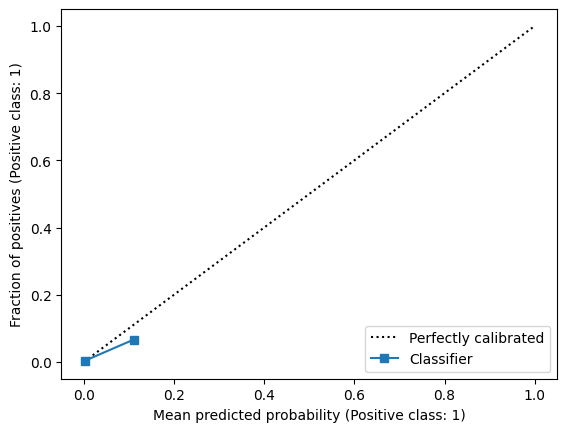

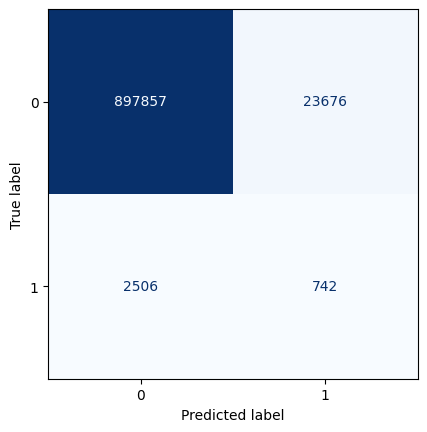

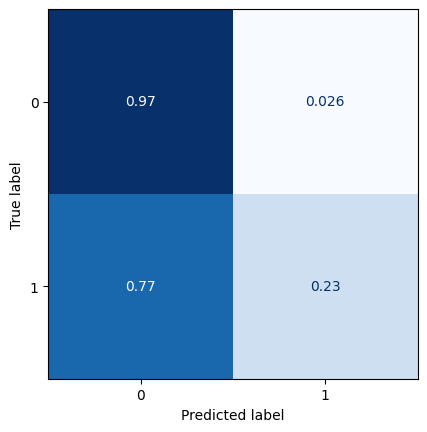

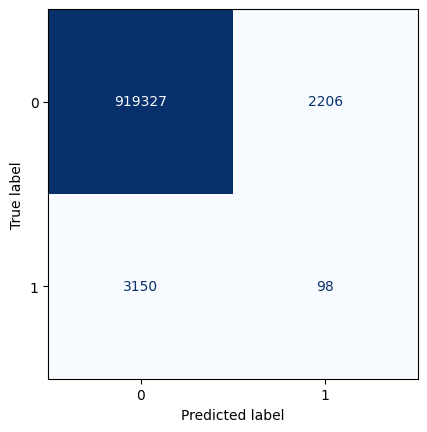

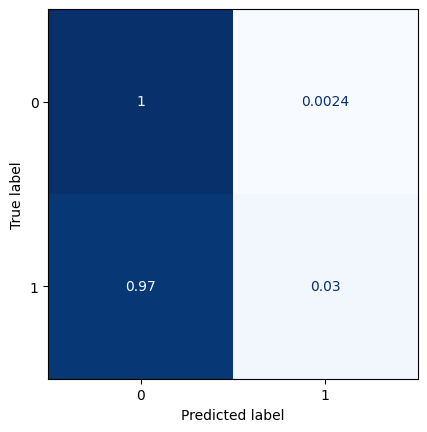

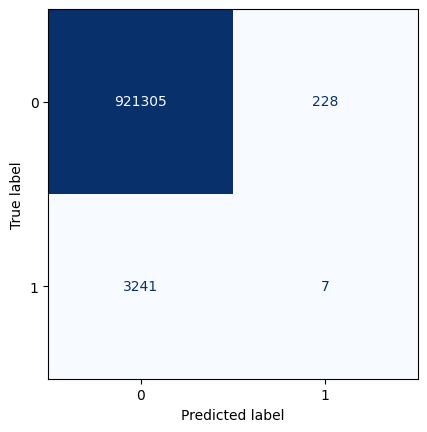

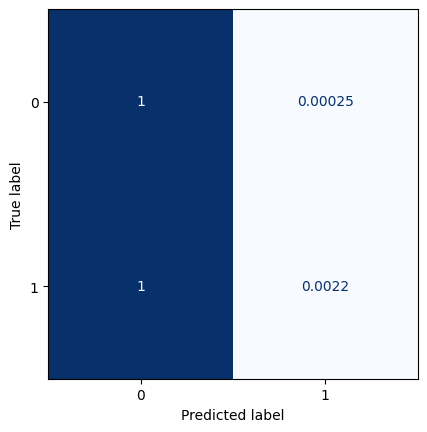

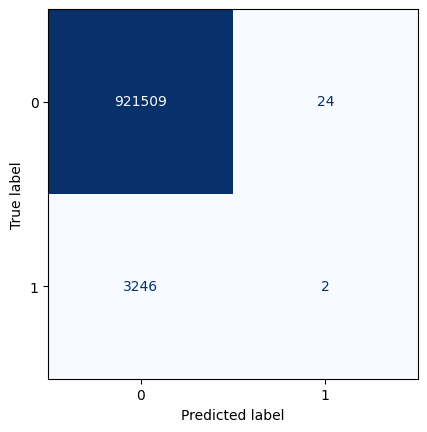

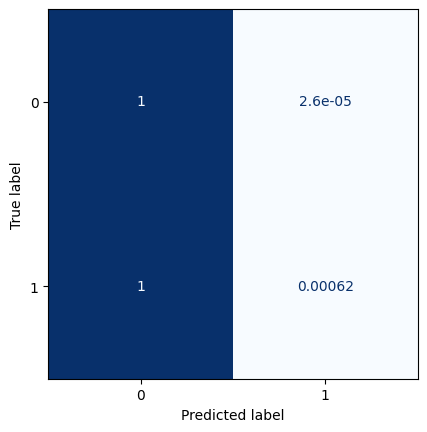

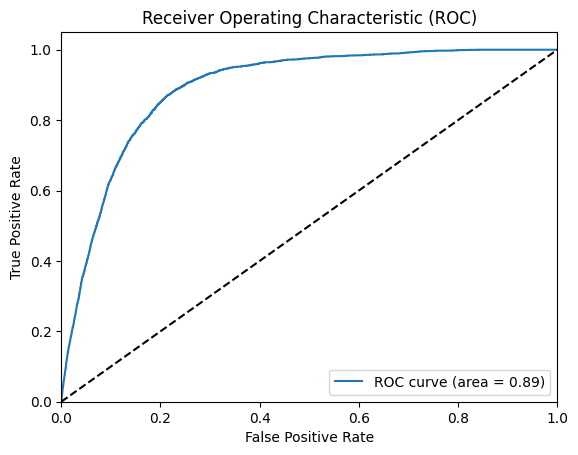

All zeros Brier score: 0.0035121828843801936
Model Brier score: 0.0034549398664281204


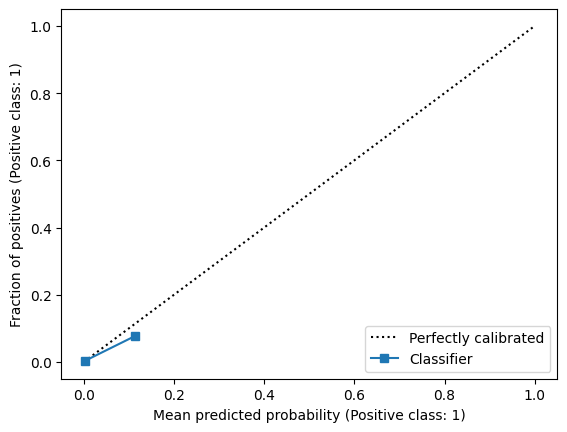

In [17]:
for lag in [1,2,3,4,5,6,7,8,9,10,11,12,13]:    
    
    model = Sequential()
    model.add(layers.Input(shape=(73,144, 9)))
    
    model.add(layers.Conv2D(8, (5,5), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((3,3), padding='same'))
    
    #model.add(layers.Flatten())
    
    #model.add(layers.Reshape((2,4,16)))
    
    model.add(layers.Conv2D(8, (5,5), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((3,3), padding='same'))
    
    model.add(layers.Conv2D(8, (5,5), activation='relu', padding='same'))
    model.add(layers.UpSampling2D((2,2)))
    
    model.add(layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')) # sigmoidal activation to have probabilities
    
    model.add(layers.Cropping2D(cropping=((2,3),(1,2))))
    
    model.summary()
    
    model.compile(loss='binary_crossentropy', optimizer='adam')
    
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=10, 
            verbose=1, mode='auto', restore_best_weights=True)
    
    train_path = '/Users/paolo/Documents/TC_old/data/earth_features/train_imgs/'
    train_target_path = '/Users/paolo/Desktop/TC_world/train_target_img.pkl'
    val_path = '/Users/paolo/Documents/TC_old/data/earth_features/val_imgs/'
    val_target_path = '/Users/paolo/Desktop/TC_world/val_target_img.pkl'
    
    train_gen = Generator(train_path, train_target_path, 1980, 2010, lag)
    val_gen = Generator(val_path, val_target_path, 2011, 2015, lag)
    
    #Model.fit(train_gen, epochs=100, steps_per_epoch=Number_of_sampels//32)
    model.fit(train_gen, validation_data=val_gen,
            callbacks=[monitor],epochs=100, steps_per_epoch=31, validation_steps=5)
    
    t2016 = model.predict(x2016[:,:,:,:-1])
    t2017 = model.predict(x2017[:,:,:,:-1])
    t2018 = model.predict(x2018[:,:,:,:-1])
    t2019 = model.predict(x2019[:,:,:,:-1])
    t2020 = model.predict(x2020[:,:,:,:-1])
    t2021 = model.predict(x2021[:,:,:,:-1])
    t2022 = model.predict(x2022[:-lag,:,:,:-1])
    t = np.concatenate((t2016,t2017,t2018,t2019,t2020,t2021,t2022))
    
    evaluate_perf(t,test_target[lag:],day=0)
    
    test = pd.read_csv('test_with_newTarget_predictions_CNNglobal.csv')
    z = np.zeros((lag,13,29,1))
    tt = np.concatenate((t,z))
    test['predictions_lag'+str(lag)] = tt.reshape(-1,1)
    test.to_csv("test_with_newTarget_predictions_CNNglobal.csv")



## Local test lag 0

In [5]:
def Generator(File_address, target_address, year_start, year_end):
    #while True:
    pickle_target = pd.read_pickle(target_address)
    
        #with (open(File_address, "rb")) as openfile: 
        #    while True:
        #        pickle_data.append(pickle.load(openfile))
        #with (open(target_address, "rb")) as openfile: 
        #        pickle_target.append(pickle.load(openfile))
    while True:
        i=0
        for year in range(year_start,year_end+1):
            X = np.load(File_address+'img_'+str(year)+'.npy')
            X = X[:,:,:,:-1]
            X = X[:,36:49,80:109,:]
            Y = pickle_target[i:i+X.shape[0]] 
            i += X.shape[0]
            yield X, Y

In [6]:
model = Sequential()
model.add(layers.Input(shape=(13, 29, 9)))

model.add(layers.Conv2D(8, (3,3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2), padding='same'))

#model.add(layers.Flatten())

#model.add(layers.Reshape((2,4,16)))

model.add(layers.Conv2D(8, (3,3), activation='relu', padding='same'))
model.add(layers.UpSampling2D((2,2)))

model.add(layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')) # sigmoidal activation to have probabilities

model.add(layers.Cropping2D(cropping=((0,1),(0,1))))

model.summary()


model.compile(loss='binary_crossentropy', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=10, 
        verbose=1, mode='auto', restore_best_weights=True)


Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 13, 29, 8)         656       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 7, 15, 8)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 15, 8)          584       
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 30, 8)        0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 30, 1)         73        
                                                                 
 cropping2d (Cropping2D)  

2023-06-22 11:12:57.635814: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-22 11:12:57.636205: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
train_path = '/Users/paolo/Documents/TC_old/data/earth_features/train_imgs/'
train_target_path = '/Users/paolo/Desktop/TC_world/train_target_img.pkl'
val_path = '/Users/paolo/Documents/TC_old/data/earth_features/val_imgs/'
val_target_path = '/Users/paolo/Desktop/TC_world/val_target_img.pkl'

train_gen = Generator(train_path, train_target_path, 1980, 2010)
val_gen = Generator(val_path, val_target_path, 2011, 2015)

#Model.fit(train_gen, epochs=100, steps_per_epoch=Number_of_sampels//32)
model.fit(train_gen, validation_data=val_gen,
        callbacks=[monitor],epochs=100, steps_per_epoch=31, validation_steps=5)

Epoch 1/100


2023-06-22 11:12:59.032010: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-06-22 11:12:59.229666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - ETA: 0s - loss: 0.4780

2023-06-22 11:13:06.855874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 9s 286ms/step - loss: 0.4780 - val_loss: 0.1691
Epoch 2/100
31/31 [==============================] - 7s 243ms/step - loss: 0.0759 - val_loss: 0.0380
Epoch 3/100
31/31 [==============================] - 11s 350ms/step - loss: 0.0382 - val_loss: 0.0311
Epoch 4/100
31/31 [==============================] - 11s 359ms/step - loss: 0.0327 - val_loss: 0.0271
Epoch 5/100
31/31 [==============================] - 20s 659ms/step - loss: 0.0294 - val_loss: 0.0241
Epoch 6/100
31/31 [==============================] - 12s 385ms/step - loss: 0.0268 - val_loss: 0.0218
Epoch 7/100
31/31 [==============================] - 12s 368ms/step - loss: 0.0246 - val_loss: 0.0199
Epoch 8/100
31/31 [==============================] - 14s 441ms/step - loss: 0.0228 - val_loss: 0.0183
Epoch 9/100
31/31 [==============================] - 13s 428ms/step - loss: 0.0212 - val_loss: 0.0169
Epoch 10/100
31/31 [==============================] - 12s 386ms/step - loss: 0.0199 - val_loss: 

In [8]:
model.fit(train_gen, validation_data=val_gen,
        callbacks=[monitor],epochs=100, steps_per_epoch=31, validation_steps=5)

Epoch 1/100
31/31 [==============================] - 7s 219ms/step - loss: 0.0101 - val_loss: 0.0081
Epoch 2/100
31/31 [==============================] - 7s 212ms/step - loss: 0.0101 - val_loss: 0.0081
Epoch 3/100
31/31 [==============================] - 11s 375ms/step - loss: 0.0100 - val_loss: 0.0081
Epoch 4/100
31/31 [==============================] - 7s 229ms/step - loss: 0.0100 - val_loss: 0.0081
Epoch 5/100
31/31 [==============================] - 9s 309ms/step - loss: 0.0100 - val_loss: 0.0081
Epoch 6/100
31/31 [==============================] - 8s 267ms/step - loss: 0.0100 - val_loss: 0.0081
Epoch 7/100
31/31 [==============================] - 8s 262ms/step - loss: 0.0100 - val_loss: 0.0080
Epoch 8/100
31/31 [==============================] - 7s 239ms/step - loss: 0.0100 - val_loss: 0.0080
Epoch 9/100
31/31 [==============================] - 7s 237ms/step - loss: 0.0100 - val_loss: 0.0080
Epoch 10/100
31/31 [==============================] - 14s 458ms/step - loss: 0.0100 - val_

In [9]:
model.fit(train_gen, validation_data=val_gen,
        callbacks=[monitor],epochs=100, steps_per_epoch=31, validation_steps=5)

Epoch 1/100
31/31 [==============================] - 7s 222ms/step - loss: 0.0091 - val_loss: 0.0076
Epoch 2/100
31/31 [==============================] - 7s 216ms/step - loss: 0.0091 - val_loss: 0.0076
Epoch 3/100
31/31 [==============================] - 8s 247ms/step - loss: 0.0091 - val_loss: 0.0076
Epoch 4/100
31/31 [==============================] - 9s 283ms/step - loss: 0.0091 - val_loss: 0.0076
Epoch 5/100
31/31 [==============================] - 7s 212ms/step - loss: 0.0091 - val_loss: 0.0076
Epoch 6/100
31/31 [==============================] - 7s 227ms/step - loss: 0.0091 - val_loss: 0.0076
Epoch 7/100
31/31 [==============================] - 8s 275ms/step - loss: 0.0091 - val_loss: 0.0076
Epoch 8/100
31/31 [==============================] - 7s 242ms/step - loss: 0.0091 - val_loss: 0.0076
Epoch 9/100
31/31 [==============================] - 7s 221ms/step - loss: 0.0091 - val_loss: 0.0076
Epoch 10/100
31/31 [==============================] - 7s 229ms/step - loss: 0.0091 - val_lo

## Flattening lag 0

In [16]:
model = Sequential()
model.add(layers.Input(shape=(73,144, 9)))

model.add(layers.Conv2D(8, (5,5), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((3,3), padding='same'))

model.add(layers.Conv2D(8, (5,5), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((3,3), padding='same'))

model.add(layers.Flatten())
model.add(layers.Dense(64))
model.add(layers.Reshape((4,16,1)))

model.add(layers.Conv2D(8, (5,5), activation='relu', padding='same'))
model.add(layers.UpSampling2D((4,2)))

model.add(layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')) # sigmoidal activation to have probabilities

model.add(layers.Cropping2D(cropping=((1,2),(1,2))))

model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=10, 
        verbose=1, mode='auto', restore_best_weights=True)


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 73, 144, 8)        1808      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 25, 48, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 25, 48, 8)         1608      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 9, 16, 8)         0         
 g2D)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 1152)              0         
                                                                 
 dense_7 (Dense)             (None, 64)               

In [17]:
train_path = '/Users/paolo/Documents/TC_old/data/earth_features/train_imgs/'
train_target_path = '/Users/paolo/Desktop/TC_world/train_target_img.pkl'
val_path = '/Users/paolo/Documents/TC_old/data/earth_features/val_imgs/'
val_target_path = '/Users/paolo/Desktop/TC_world/val_target_img.pkl'

train_gen = Generator(train_path, train_target_path, 1980, 2010)
val_gen = Generator(val_path, val_target_path, 2011, 2015)

#Model.fit(train_gen, epochs=100, steps_per_epoch=Number_of_sampels//32)
model.fit(train_gen, validation_data=val_gen,
        callbacks=[monitor],epochs=100, steps_per_epoch=31, validation_steps=5)

Epoch 1/100


2023-08-02 15:06:12.212586: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-08-02 15:06:12.576424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - ETA: 0s - loss: 0.1575

2023-08-02 15:06:34.797374: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 25s 787ms/step - loss: 0.1575 - val_loss: 0.0484
Epoch 2/100
31/31 [==============================] - 28s 871ms/step - loss: 0.0509 - val_loss: 0.0410
Epoch 3/100
31/31 [==============================] - 22s 687ms/step - loss: 0.0424 - val_loss: 0.0336
Epoch 4/100
31/31 [==============================] - 30s 969ms/step - loss: 0.0309 - val_loss: 0.0250
Epoch 5/100
31/31 [==============================] - 36s 1s/step - loss: 0.0252 - val_loss: 0.0221
Epoch 6/100
31/31 [==============================] - 35s 1s/step - loss: 0.0231 - val_loss: 0.0206
Epoch 7/100
31/31 [==============================] - 25s 787ms/step - loss: 0.0222 - val_loss: 0.0200
Epoch 8/100
31/31 [==============================] - 27s 775ms/step - loss: 0.0218 - val_loss: 0.0198
Epoch 9/100
31/31 [==============================] - 57s 2s/step - loss: 0.0215 - val_loss: 0.0196
Epoch 10/100
31/31 [==============================] - 54s 2s/step - loss: 0.0213 - val_loss: 0.0195
Epo

In [18]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=20, 
        verbose=1, mode='auto', restore_best_weights=True)

model.fit(train_gen, validation_data=val_gen,
        callbacks=[monitor],epochs=100, steps_per_epoch=31, validation_steps=5)

Epoch 1/100
31/31 [==============================] - 55s 2s/step - loss: 0.0134 - val_loss: 0.0163
Epoch 2/100
31/31 [==============================] - 42s 1s/step - loss: 0.0128 - val_loss: 0.0168
Epoch 3/100
31/31 [==============================] - 32s 1s/step - loss: 0.0125 - val_loss: 0.0165
Epoch 4/100
31/31 [==============================] - 42s 1s/step - loss: 0.0121 - val_loss: 0.0161
Epoch 5/100
31/31 [==============================] - 46s 2s/step - loss: 0.0117 - val_loss: 0.0160
Epoch 6/100
31/31 [==============================] - 42s 1s/step - loss: 0.0114 - val_loss: 0.0162
Epoch 7/100
31/31 [==============================] - 43s 1s/step - loss: 0.0113 - val_loss: 0.0165
Epoch 8/100
31/31 [==============================] - 23s 733ms/step - loss: 0.0112 - val_loss: 0.0172
Epoch 9/100
31/31 [==============================] - 41s 1s/step - loss: 0.0114 - val_loss: 0.0181
Epoch 10/100
31/31 [==============================] - 36s 1s/step - loss: 0.0117 - val_loss: 0.0194
Epoch 

## Flattening lag 3

In [19]:
def Generator(File_address, target_address, year_start, year_end, lag):
    #while True:
    pickle_target = pd.read_pickle(target_address)
    
        #with (open(File_address, "rb")) as openfile: 
        #    while True:
        #        pickle_data.append(pickle.load(openfile))
        #with (open(target_address, "rb")) as openfile: 
        #        pickle_target.append(pickle.load(openfile))
    while True:
        i=0
        for year in range(year_start,year_end+1):
            X = np.load(File_address+'img_'+str(year)+'.npy')
            Y = pickle_target[i+lag:i+X.shape[0]] 
            i += X.shape[0]
            X = X[:-lag,:,:,:-1]
            yield X, Y

In [20]:
lag=3

model = Sequential()
model.add(layers.Input(shape=(73,144, 9)))

model.add(layers.Conv2D(8, (5,5), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((3,3), padding='same'))

model.add(layers.Conv2D(8, (5,5), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((3,3), padding='same'))

model.add(layers.Flatten())
model.add(layers.Dense(64))
model.add(layers.Reshape((4,16,1)))


model.add(layers.Conv2D(8, (5,5), activation='relu', padding='same'))
model.add(layers.UpSampling2D((4,2)))

model.add(layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')) # sigmoidal activation to have probabilities

model.add(layers.Cropping2D(cropping=((1,2),(1,2))))

model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=20, 
        verbose=1, mode='auto', restore_best_weights=True)

train_path = '/Users/paolo/Documents/TC_old/data/earth_features/train_imgs/'
train_target_path = '/Users/paolo/Desktop/TC_world/train_target_img.pkl'
val_path = '/Users/paolo/Documents/TC_old/data/earth_features/val_imgs/'
val_target_path = '/Users/paolo/Desktop/TC_world/val_target_img.pkl'

train_gen = Generator(train_path, train_target_path, 1980, 2010, lag)
val_gen = Generator(val_path, val_target_path, 2011, 2015, lag)

model.fit(train_gen, validation_data=val_gen,
        callbacks=[monitor],epochs=100, steps_per_epoch=31, validation_steps=5)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_31 (Conv2D)          (None, 73, 144, 8)        1808      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 25, 48, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 25, 48, 8)         1608      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 9, 16, 8)         0         
 g2D)                                                            
                                                                 
 flatten_9 (Flatten)         (None, 1152)              0         
                                                                 
 dense_8 (Dense)             (None, 64)               

2023-08-02 16:12:37.680611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - ETA: 0s - loss: 0.0997

2023-08-02 16:13:41.196147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 70s 2s/step - loss: 0.0997 - val_loss: 0.0547
Epoch 2/100
31/31 [==============================] - 37s 1s/step - loss: 0.0633 - val_loss: 0.0543
Epoch 3/100
31/31 [==============================] - 43s 1s/step - loss: 0.0616 - val_loss: 0.0481
Epoch 4/100
31/31 [==============================] - 30s 974ms/step - loss: 0.0358 - val_loss: 0.0234
Epoch 5/100
31/31 [==============================] - 38s 1s/step - loss: 0.0245 - val_loss: 0.0202
Epoch 6/100
31/31 [==============================] - 32s 939ms/step - loss: 0.0225 - val_loss: 0.0198
Epoch 7/100
31/31 [==============================] - 31s 997ms/step - loss: 0.0217 - val_loss: 0.0194
Epoch 8/100
31/31 [==============================] - 26s 816ms/step - loss: 0.0211 - val_loss: 0.0192
Epoch 9/100
31/31 [==============================] - 32s 1s/step - loss: 0.0206 - val_loss: 0.0190
Epoch 10/100
31/31 [==============================] - 37s 1s/step - loss: 0.0202 - val_loss: 0.0188
Epoch 11/

# Pretrained ResNet

In [1]:
def Generator(File_address, target_address, year_start, year_end):
    #while True:
    pickle_target = pd.read_pickle(target_address)
    
        #with (open(File_address, "rb")) as openfile: 
        #    while True:
        #        pickle_data.append(pickle.load(openfile))
        #with (open(target_address, "rb")) as openfile: 
        #        pickle_target.append(pickle.load(openfile))
    while True:
        i=0
        for year in range(year_start,year_end+1):
            X = np.load(File_address+'img_'+str(year)+'.npy')
            X = X[:,:,:,:-1]
            Y = pickle_target[i:i+X.shape[0]] 
            i += X.shape[0]
            yield X, Y

In [18]:
from keras.layers import Conv2DTranspose as DeConv

input_layer = Input(shape=(73,144, 9))

conv0 = (layers.Conv2D(3, (3,3), activation='relu', padding='same'))(input_layer)

resnet = tf.keras.applications.ResNet50(
    input_shape=(73,144, 3),
    weights='imagenet',
    include_top=False,  
    input_tensor=None,
    pooling=None
    )
resnet.trainable = False

res_features = resnet(conv0)

conv = DeConv(1, padding="valid", activation="sigmoid", kernel_size=3)(res_features)
convUp = (layers.UpSampling2D((3,5)))(conv)

convUp = layers.Cropping2D(cropping=((1,1),(3,3)))(convUp)


model = Model(inputs=input_layer, outputs=convUp)
    
model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=5, 
        verbose=1, mode='auto', restore_best_weights=True)

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 73, 144, 9)]      0         
                                                                 
 conv2d_13 (Conv2D)          (None, 73, 144, 3)        246       
                                                                 
 resnet50 (Functional)       (None, 3, 5, 2048)        23587712  
                                                                 
 conv2d_transpose_13 (Conv2D  (None, 5, 7, 1)          18433     
 Transpose)                                                      
                                                                 
 up_sampling2d_6 (UpSampling  (None, 15, 35, 1)        0         
 2D)                                                             
                                                                 
 cropping2d_5 (Cropping2D)   (None, 13, 29, 1)         0  

In [19]:
train_path = '/Users/paolo/Documents/TC_old/data/earth_features/train_imgs/'
train_target_path = '/Users/paolo/Desktop/TC_world/train_target_img.pkl'
val_path = '/Users/paolo/Documents/TC_old/data/earth_features/val_imgs/'
val_target_path = '/Users/paolo/Desktop/TC_world/val_target_img.pkl'

train_gen = Generator(train_path, train_target_path, 1980, 2010)
val_gen = Generator(val_path, val_target_path, 2011, 2015)

#Model.fit(train_gen, epochs=100, steps_per_epoch=Number_of_sampels//32)
model.fit(train_gen, validation_data=val_gen,
        callbacks=[monitor],epochs=100, steps_per_epoch=31, validation_steps=5)

Epoch 1/100


2023-06-28 12:33:50.424452: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - ETA: 0s - loss: 0.1371

2023-06-28 12:38:47.326472: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 305s 10s/step - loss: 0.1371 - val_loss: 0.0540
Epoch 2/100
31/31 [==============================] - 293s 9s/step - loss: 0.0530 - val_loss: 0.0400
Epoch 3/100
31/31 [==============================] - 298s 10s/step - loss: 0.0380 - val_loss: 0.0294
Epoch 4/100
31/31 [==============================] - 309s 10s/step - loss: 0.0293 - val_loss: 0.0251
Epoch 5/100
31/31 [==============================] - 311s 10s/step - loss: 0.0264 - val_loss: 0.0233
Epoch 6/100
31/31 [==============================] - 304s 10s/step - loss: 0.0249 - val_loss: 0.0222
Epoch 7/100
31/31 [==============================] - 306s 10s/step - loss: 0.0240 - val_loss: 0.0216
Epoch 8/100
31/31 [==============================] - 295s 9s/step - loss: 0.0234 - val_loss: 0.0211
Epoch 9/100
31/31 [==============================] - 293s 9s/step - loss: 0.0229 - val_loss: 0.0208
Epoch 10/100
31/31 [==============================] - 290s 9s/step - loss: 0.0226 - val_loss: 0.0205
Epoch

2023-06-28 19:15:59.201914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 2s 126ms/step


NameError: name 'plot_roc' is not defined

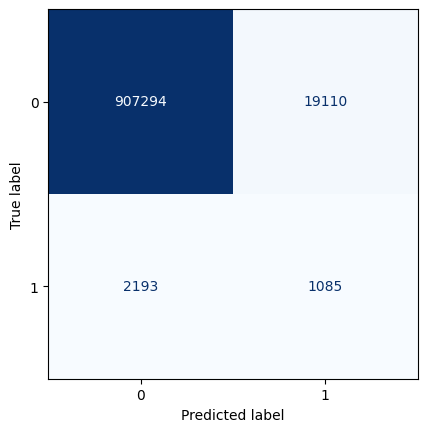

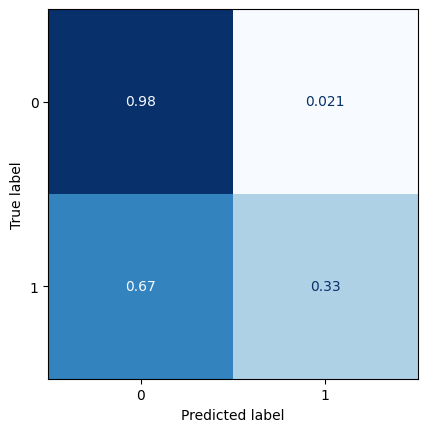

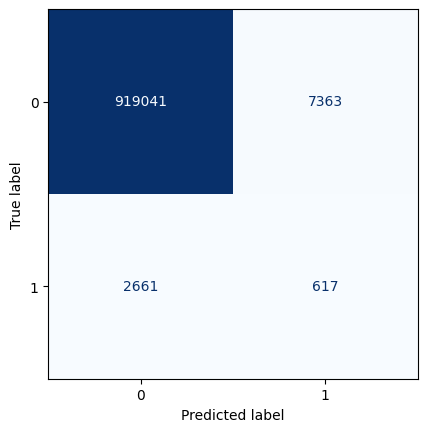

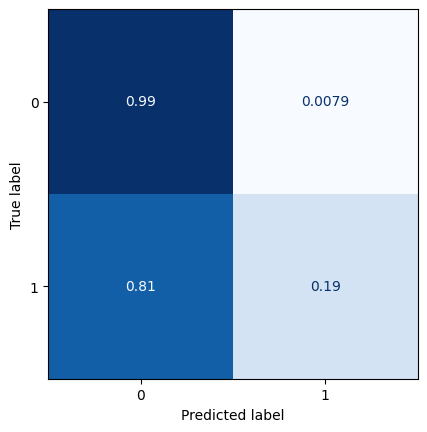

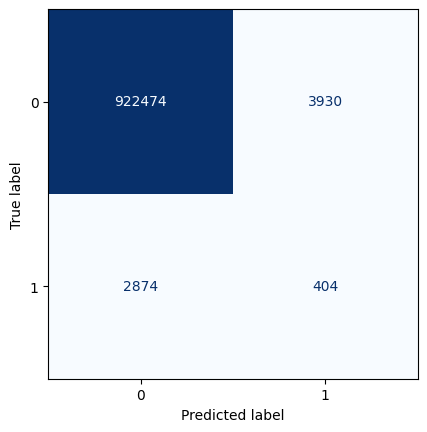

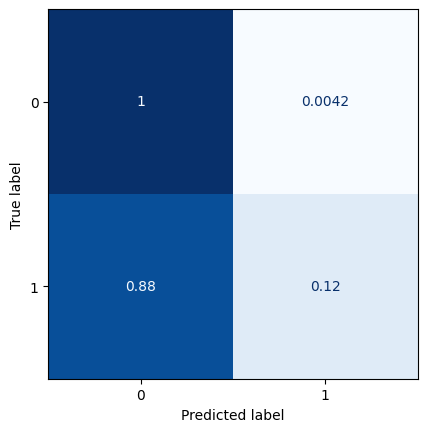

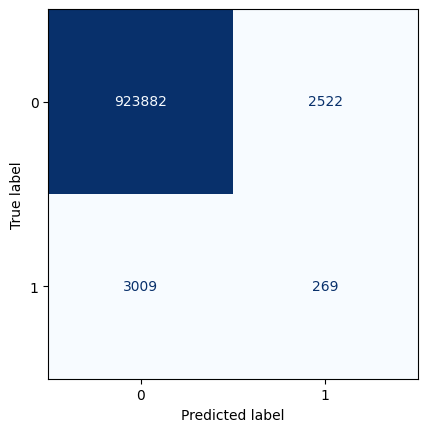

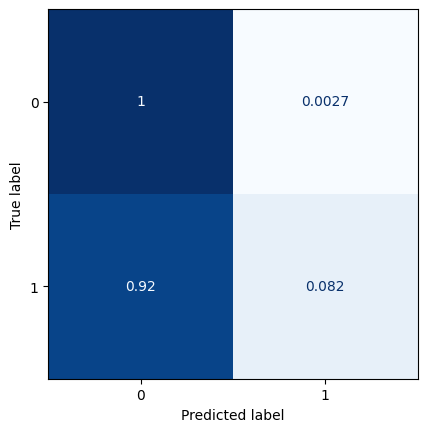

In [21]:
x2016 = np.load('/Users/paolo/Documents/TC_old/data/earth_features/test_imgs/2016/img_2016.npy')
x2016 = x2016[91:]
x2017 = np.load('/Users/paolo/Documents/TC_old/data/earth_features/test_imgs/2017/img_2017.npy')
x2018 = np.load('/Users/paolo/Documents/TC_old/data/earth_features/test_imgs/2018/img_2018.npy')
x2019 = np.load('/Users/paolo/Documents/TC_old/data/earth_features/test_imgs/2019/img_2019.npy')
x2020 = np.load('/Users/paolo/Documents/TC_old/data/earth_features/test_imgs/2020/img_2020.npy')
x2021 = np.load('/Users/paolo/Documents/TC_old/data/earth_features/test_imgs/2021/img_2021.npy')
x2022 = np.load('/Users/paolo/Documents/TC_old/data/earth_features/test_imgs/2022/img_2022.npy')

x_test = np.concatenate((x2016,x2017,x2018,x2019,x2020,x2021,x2022), axis=0)

test_target = pd.read_pickle('/Users/paolo/Desktop/TC_world/test_target_img.pkl')

t2016 = model.predict(x2016[:,:,:,:-1])
t2017 = model.predict(x2017[:,:,:,:-1])
t2018 = model.predict(x2018[:,:,:,:-1])
t2019 = model.predict(x2019[:,:,:,:-1])
t2020 = model.predict(x2020[:,:,:,:-1])
t2021 = model.predict(x2021[:,:,:,:-1])
t2022 = model.predict(x2022[:,:,:,:-1])
t = np.concatenate((t2016,t2017,t2018,t2019,t2020,t2021,t2022))

evaluate_perf(t,test_target,day=0)



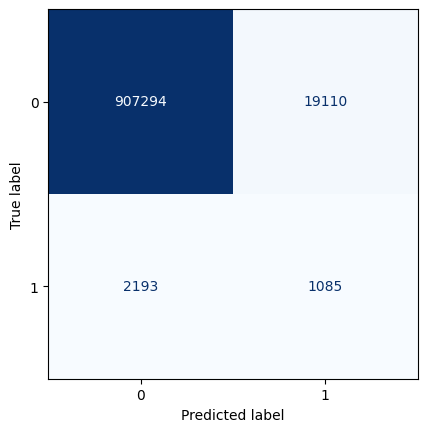

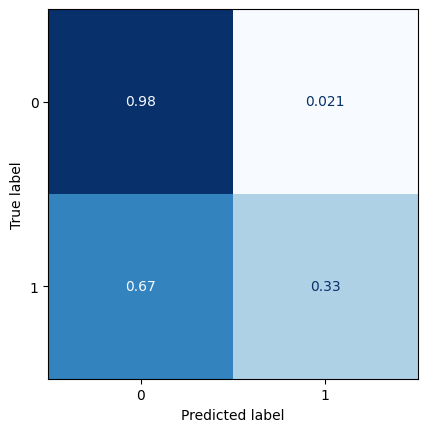

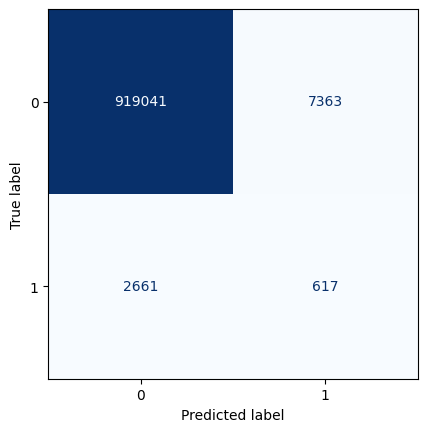

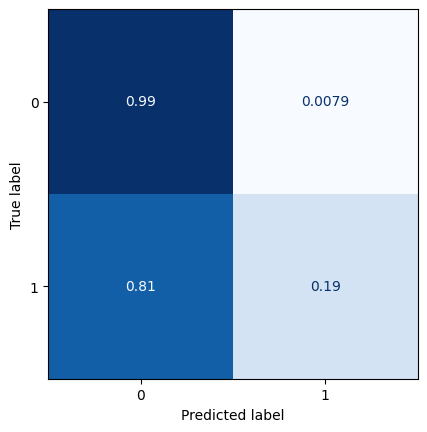

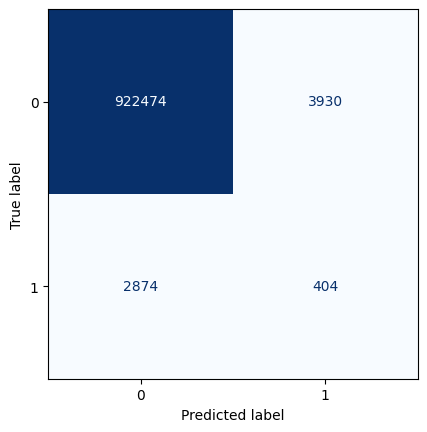

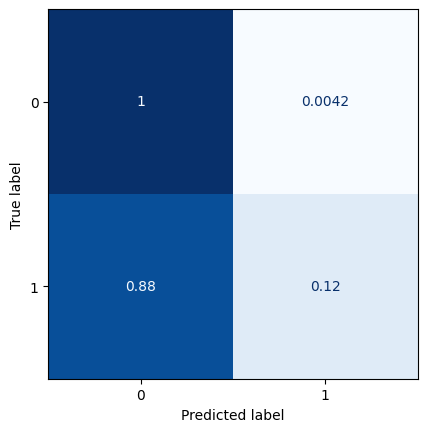

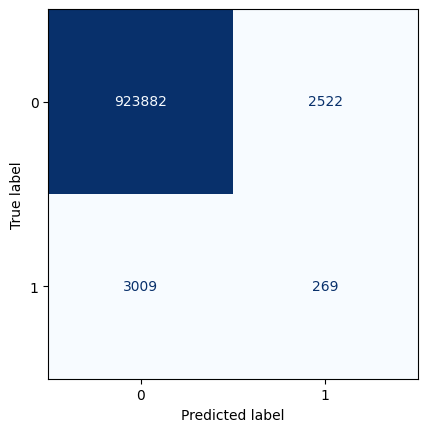

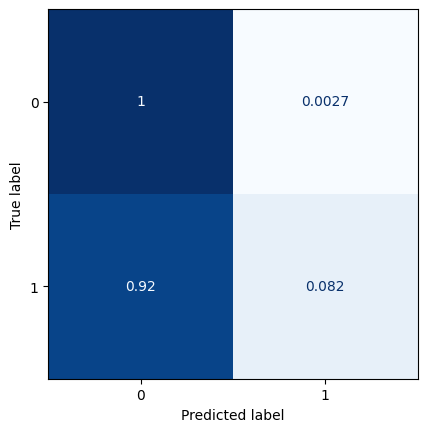

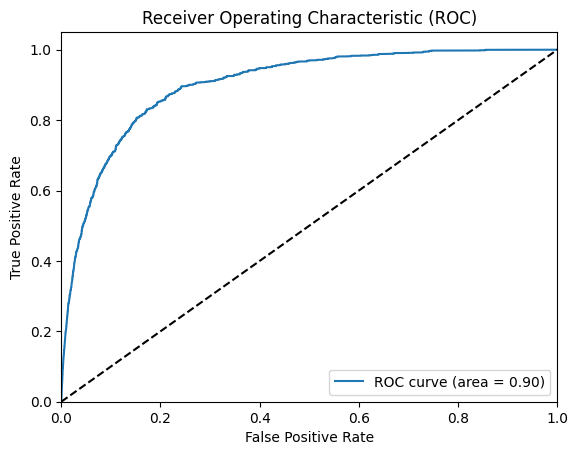

All zeros Brier score: 0.0035259368257102965
Model Brier score: 0.0034610983728701225


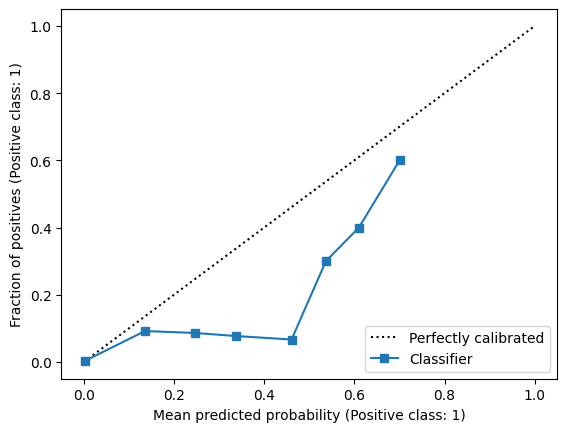

In [23]:
evaluate_perf(t,test_target,day=0)


In [24]:
test = pd.read_csv('/Users/paolo/Documents/TC_old/data/NewData_csv/test_sets_withrealtom.csv')
test = test.loc[test.time>='2016-04-01']
test['predictions_lag0'] = t.reshape(-1,1)
test.to_csv("test_with_newTarget_predictions_CNNglobal_ResNet.csv")

### Lag=1

In [5]:
def Generator(File_address, target_address, year_start, year_end, lag):
    #while True:
    pickle_target = pd.read_pickle(target_address)
    
        #with (open(File_address, "rb")) as openfile: 
        #    while True:
        #        pickle_data.append(pickle.load(openfile))
        #with (open(target_address, "rb")) as openfile: 
        #        pickle_target.append(pickle.load(openfile))
    while True:
        i=0
        for year in range(year_start,year_end+1):
            X = np.load(File_address+'img_'+str(year)+'.npy')
            Y = pickle_target[i+lag:i+X.shape[0]] 
            i += X.shape[0]
            X = X[:-lag,:,:,:-1]
            yield X, Y

In [6]:
x2016 = np.load('/Users/paolo/Documents/TC_old/data/earth_features/test_imgs/2016/img_2016.npy')
x2016 = x2016[91:]
x2017 = np.load('/Users/paolo/Documents/TC_old/data/earth_features/test_imgs/2017/img_2017.npy')
x2018 = np.load('/Users/paolo/Documents/TC_old/data/earth_features/test_imgs/2018/img_2018.npy')
x2019 = np.load('/Users/paolo/Documents/TC_old/data/earth_features/test_imgs/2019/img_2019.npy')
x2020 = np.load('/Users/paolo/Documents/TC_old/data/earth_features/test_imgs/2020/img_2020.npy')
x2021 = np.load('/Users/paolo/Documents/TC_old/data/earth_features/test_imgs/2021/img_2021.npy')
x2022 = np.load('/Users/paolo/Documents/TC_old/data/earth_features/test_imgs/2022/img_2022.npy')
test_target = pd.read_pickle('/Users/paolo/Desktop/TC_world/test_target_img.pkl')


In [7]:
def evaluate_perf(t,test_outputs,day=0):
    one_day_t = t
    one_day_y = test_outputs
    
    ranges = [0.025,0.05,0.075,0.1]
    
    for j in ranges:
        classes = []
        for i in one_day_t.reshape(-1,1):
            if i<=j: classes.append(0)
            else: classes.append(1)
    
    # confusion matrix with threshold on 0.1, otherwise always 0 
        ConfusionMatrixDisplay(confusion_matrix(one_day_y.reshape(-1,1), classes)).plot(colorbar=False,cmap=plt.cm.Blues, values_format='d')
        ConfusionMatrixDisplay(confusion_matrix(one_day_y.reshape(-1,1), classes, normalize='true')).plot(colorbar=False,cmap=plt.cm.Blues)
    
    plot_roc(one_day_t.reshape(-1,1),one_day_y.reshape(-1,1))
    
    display = CalibrationDisplay.from_predictions(one_day_y.reshape(-1,1), one_day_t.reshape(-1,1), n_bins=10)

    print(f'All zeros Brier score: {brier_score_loss(one_day_y.reshape(-1,1), np.zeros(len(one_day_y.reshape(-1,1))))}')
    print(f'Model Brier score: {brier_score_loss(one_day_y.reshape(-1,1), one_day_t.reshape(-1,1))}')
    

In [ ]:
from keras.layers import Conv2DTranspose as DeConv

for lag in [2,3]:    
    
    input_layer = Input(shape=(73,144, 9))

    conv0 = (layers.Conv2D(3, (3,3), activation='relu', padding='same'))(input_layer)
    
    resnet = tf.keras.applications.ResNet50(
        input_shape=(73,144, 3),
        weights='imagenet',
        include_top=False,  
        input_tensor=None,
        pooling=None
        )
    resnet.trainable = False
    
    res_features = resnet(conv0)
    
    conv = DeConv(1, padding="valid", activation="sigmoid", kernel_size=3)(res_features)
    convUp = (layers.UpSampling2D((3,5)))(conv)
    
    convUp = layers.Cropping2D(cropping=((1,1),(3,3)))(convUp)
    
    
    model = Model(inputs=input_layer, outputs=convUp)
        
    model.summary()
    
    model.compile(loss='binary_crossentropy', optimizer='adam')
    
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=5, 
            verbose=1, mode='auto', restore_best_weights=True)
    
    train_path = '/Users/paolo/Documents/TC_old/data/earth_features/train_imgs/'
    train_target_path = '/Users/paolo/Desktop/TC_world/train_target_img.pkl'
    val_path = '/Users/paolo/Documents/TC_old/data/earth_features/val_imgs/'
    val_target_path = '/Users/paolo/Desktop/TC_world/val_target_img.pkl'
    
    train_gen = Generator(train_path, train_target_path, 1980, 2010, lag)
    val_gen = Generator(val_path, val_target_path, 2011, 2015, lag)
    
    #Model.fit(train_gen, epochs=100, steps_per_epoch=Number_of_sampels//32)
    model.fit(train_gen, validation_data=val_gen,
            callbacks=[monitor],epochs=100, steps_per_epoch=31, validation_steps=5)
    
    t2016 = model.predict(x2016[:,:,:,:-1])
    t2017 = model.predict(x2017[:,:,:,:-1])
    t2018 = model.predict(x2018[:,:,:,:-1])
    t2019 = model.predict(x2019[:,:,:,:-1])
    t2020 = model.predict(x2020[:,:,:,:-1])
    t2021 = model.predict(x2021[:,:,:,:-1])
    t2022 = model.predict(x2022[:-lag,:,:,:-1])
    t = np.concatenate((t2016,t2017,t2018,t2019,t2020,t2021,t2022))
    
    evaluate_perf(t,test_target[lag:],day=0)
    
    test = pd.read_csv('test_with_newTarget_predictions_CNNglobal_ResNet.csv')
    z = np.zeros((lag,13,29,1))
    tt = np.concatenate((t,z))
    test['predictions_lag'+str(lag)] = tt.reshape(-1,1)
    test.to_csv("test_with_newTarget_predictions_CNNglobal_ResNet.csv")



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 73, 144, 9)]      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 73, 144, 3)        246       
                                                                 
 resnet50 (Functional)       (None, 3, 5, 2048)        23587712  
                                                                 
 conv2d_transpose (Conv2DTra  (None, 5, 7, 1)          18433     
 nspose)                                                         
                                                                 
 up_sampling2d (UpSampling2D  (None, 15, 35, 1)        0         
 )                                                               
                                                                 
 cropping2d (Cropping2D)     (None, 13, 29, 1)         0     

2023-06-29 08:34:29.294693: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-06-29 08:34:30.266890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - ETA: 0s - loss: 0.1259

2023-06-29 08:39:19.732110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 298s 10s/step - loss: 0.1259 - val_loss: 0.0531
Epoch 2/100
31/31 [==============================] - 285s 9s/step - loss: 0.0493 - val_loss: 0.0339
Epoch 3/100
31/31 [==============================] - 310s 10s/step - loss: 0.0331 - val_loss: 0.0273
Epoch 4/100
31/31 [==============================] - 311s 10s/step - loss: 0.0282 - val_loss: 0.0243
Epoch 5/100
31/31 [==============================] - 297s 10s/step - loss: 0.0260 - val_loss: 0.0228
Epoch 6/100
31/31 [==============================] - 326s 10s/step - loss: 0.0247 - val_loss: 0.0220
Epoch 7/100
31/31 [==============================] - 347s 11s/step - loss: 0.0240 - val_loss: 0.0218
Epoch 8/100
 1/31 [..............................] - ETA: 6:15 - loss: 0.0211

# U-Net

## Lag=0

In [5]:
# Full Earth

def Generator(File_address, target_address, year_start, year_end):
    #while True:
    pickle_target = pd.read_pickle(target_address)
    
        #with (open(File_address, "rb")) as openfile: 
        #    while True:
        #        pickle_data.append(pickle.load(openfile))
        #with (open(target_address, "rb")) as openfile: 
        #        pickle_target.append(pickle.load(openfile))
    while True:
        i=0
        for year in range(year_start,year_end+1):
            X = np.load(File_address+'img_'+str(year)+'.npy')
            X = X[:,:,:,:-1]
            Y = pickle_target[i:i+X.shape[0]] 
            i += X.shape[0]
            
            pad_tns = tf.constant([ [0,0], [3,4], [8,8], [0,0] ])
            X = np.array(tf.pad(X,pad_tns,mode='CONSTANT',constant_values=0))
            yield X, Y

In [8]:
# u-net model 

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda, Cropping2D

################################################################
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    #u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    #u8 = concatenate([u8, c2])
    #c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    #c8 = Dropout(0.1)(c8)
    #c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    # 
    #u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    #u9 = concatenate([u9, c1], axis=3)
    #c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    #c9 = Dropout(0.1)(c9)
    #c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    
    c10 = Cropping2D(cropping=((3,4),(5,6)))(c7)
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c10)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    
    return model
 

In [19]:
def very_simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    #c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    #c3 = Dropout(0.2)(c3)
    #c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
 
    #u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c3)
    #u8 = concatenate([u8, c2])
    #c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    #c8 = Dropout(0.1)(c8)
    #c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    #u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    #u9 = concatenate([u9, c1], axis=3)
    #c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    #c9 = Dropout(0.1)(c9)
    #c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    
    c10 = Cropping2D(cropping=((3,4),(5,6)))(p2)
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c10)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    
    return model

In [20]:
very_simple_unet_model(80,160, 9)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 80, 160, 9)]      0         
                                                                 
 conv2d_39 (Conv2D)          (None, 80, 160, 16)       1312      
                                                                 
 dropout_18 (Dropout)        (None, 80, 160, 16)       0         
                                                                 
 conv2d_40 (Conv2D)          (None, 80, 160, 16)       2320      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 40, 80, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 40, 80, 32)        4640      
                                                           

In [23]:
simple_unet_model(80,160, 9)

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 80, 160, 9)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_149 (Conv2D)            (None, 80, 160, 16)  1312        ['input_11[0][0]']               
                                                                                                  
 dropout_71 (Dropout)           (None, 80, 160, 16)  0           ['conv2d_149[0][0]']             
                                                                                                  
 conv2d_150 (Conv2D)            (None, 80, 160, 16)  2320        ['dropout_71[0][0]']       

In [ ]:
model = very_simple_unet_model(80,160, 9)
model.compile(loss='binary_crossentropy', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=10, 
        verbose=1, mode='auto', restore_best_weights=True)

model.summary()

train_path = '/Users/paolo/Documents/TC_old/data/earth_features/train_imgs/'
train_target_path = '/Users/paolo/Desktop/TC_world/train_target_img.pkl'
val_path = '/Users/paolo/Documents/TC_old/data/earth_features/val_imgs/'
val_target_path = '/Users/paolo/Desktop/TC_world/val_target_img.pkl'

train_gen = Generator(train_path, train_target_path, 1980, 2010)
val_gen = Generator(val_path, val_target_path, 2011, 2015)

#Model.fit(train_gen, epochs=100, steps_per_epoch=Number_of_sampels//32)
model.fit(train_gen, validation_data=val_gen,
        callbacks=[monitor],epochs=100, steps_per_epoch=31, validation_steps=5)

x2016 = np.load('/Users/paolo/Documents/TC_old/data/earth_features/test_imgs/2016/img_2016.npy')
x2016 = x2016[91:]
x2017 = np.load('/Users/paolo/Documents/TC_old/data/earth_features/test_imgs/2017/img_2017.npy')
x2018 = np.load('/Users/paolo/Documents/TC_old/data/earth_features/test_imgs/2018/img_2018.npy')
x2019 = np.load('/Users/paolo/Documents/TC_old/data/earth_features/test_imgs/2019/img_2019.npy')
x2020 = np.load('/Users/paolo/Documents/TC_old/data/earth_features/test_imgs/2020/img_2020.npy')
x2021 = np.load('/Users/paolo/Documents/TC_old/data/earth_features/test_imgs/2021/img_2021.npy')
x2022 = np.load('/Users/paolo/Documents/TC_old/data/earth_features/test_imgs/2022/img_2022.npy')


x_test = np.concatenate((x2016,x2017,x2018,x2019,x2020,x2021,x2022), axis=0)
x_test = np.array(tf.pad(x_test,pad_tns,mode='CONSTANT',constant_values=0))
x_test.shape

test_target = pd.read_pickle('/Users/paolo/Desktop/TC_world/test_target_img.pkl')

test_target.shape

t2016 = model.predict(x2016[:,:,:,:-1])
t2017 = model.predict(x2017[:,:,:,:-1])
t2018 = model.predict(x2018[:,:,:,:-1])
t2019 = model.predict(x2019[:,:,:,:-1])
t2020 = model.predict(x2020[:,:,:,:-1])
t2021 = model.predict(x2021[:,:,:,:-1])
t2022 = model.predict(x2022[:,:,:,:-1])
t = np.concatenate((t2016,t2017,t2018,t2019,t2020,t2021,t2022))



Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 80, 160, 9)]      0         
                                                                 
 conv2d_44 (Conv2D)          (None, 80, 160, 16)       1312      
                                                                 
 dropout_20 (Dropout)        (None, 80, 160, 16)       0         
                                                                 
 conv2d_45 (Conv2D)          (None, 80, 160, 16)       2320      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 40, 80, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 40, 80, 32)        4640      
                                                           

2023-07-05 11:25:15.914486: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-07-05 11:25:16.376434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 2/31 [>.............................] - ETA: 7:41 - loss: 1.2890

In [ ]:
def evaluate_perf(t,test_outputs,day=0):
    one_day_t = t
    one_day_y = test_outputs
    
    ranges = [0.025,0.05,0.075,0.1]
    
    for j in ranges:
        classes = []
        for i in one_day_t.reshape(-1,1):
            if i<=j: classes.append(0)
            else: classes.append(1)
    
    # confusion matrix with threshold on 0.1, otherwise always 0 
        ConfusionMatrixDisplay(confusion_matrix(one_day_y.reshape(-1,1), classes)).plot(colorbar=False,cmap=plt.cm.Blues, values_format='d')
        ConfusionMatrixDisplay(confusion_matrix(one_day_y.reshape(-1,1), classes, normalize='true')).plot(colorbar=False,cmap=plt.cm.Blues)
    
    plot_roc(one_day_t.reshape(-1,1),one_day_y.reshape(-1,1))
    
    display = CalibrationDisplay.from_predictions(one_day_y.reshape(-1,1), one_day_t.reshape(-1,1), n_bins=10)

    print(f'All zeros Brier score: {brier_score_loss(one_day_y.reshape(-1,1), np.zeros(len(one_day_y.reshape(-1,1))))}')
    print(f'Model Brier score: {brier_score_loss(one_day_y.reshape(-1,1), one_day_t.reshape(-1,1))}')
    

evaluate_perf(t,test_target,day=0)

test = pd.read_csv('/Users/paolo/Documents/TC_old/data/NewData_csv/test_sets_withrealtom.csv')
test = test.loc[test.time>='2016-04-01']
test['predictions_lag0'] = t.reshape(-1,1)
test.to_csv("test_with_newTarget_predictions_CNNglobal.csv")